**SeattleStayAI:**

**Context**:

Airbnb guests in Seattle leave thousands of reviews capturing their experiences — from host communication to cleanliness and neighborhood vibe. This unstructured text holds valuable insights, but manual analysis is impractical.
SeattleStay AI applies advanced topic modeling techniques to uncover hidden themes in guest reviews, helping hosts and managers understand customer priorities and improve service quality.

**Objective**:

Clean and preprocess Airbnb review text for NLP analysis.

Extract dominant themes using LDA, NMF, and BERTopic.

Compare interpretability, coherence, and topic richness across models.

Visualize results to identify guest satisfaction drivers and problem areas.

Provide actionable insights to enhance overall guest experience.

Build a recommendation system combining the topic probabilities and the sentiment score that help the Airbnb offer listings with similar guest experiences.

**Methodology:**

**LDA:** Captures interpretable word-based themes .

**NMF:** Finds distinct, concise topics using TF-IDF features.

**BERT:** Uses BERT embeddings to reveal deeper, context-aware insights.

**Outcome:**

By turning unstructured reviews into meaningful topics and visual insights, SeattleStay AI empowers Airbnb hosts to optimize listings, personalize guest experiences, and strengthen market competitiveness.



**review.csv**

**Most useful columns** : **comments**

Others : listing_id, date

**listing.csv**

**Most useful columns** **bold text**: name, description, neighborhood_overview, amenities,

Others : host_about, host_is_superhost, host_identity_verified, neighbourhood_group_cleansed, neighbourhood_cleansed, property_type, room_type, price

**Note:**

* review_scores_rating :
For training topic models → ratings are not required.
For analyzing results → ratings are very useful for slicing, comparing, and prioritizing insights.
Rest non-numeric features if using can be used for filtering/sorting/grouping and not for training a model.
*  Using **Price** in Airbnb data with topic modeling

   price is numeric, so it doesn’t feed into the topic modeling algorithm itself (which needs text).

   You can’t discover “topics” from price values, but you can use price categories to segment your text analysis.

   How to make it useful:

   Create price bins

   e.g., budget (< $75), mid-range ($75 - 150), luxury (> $150).

   This gives you labels that can be used for grouping reviews.

   Run topic modeling on all reviews, then check how topic prevalence differs by price segment.

    Example:

    Budget → topics about “value for money,” “basic amenities.”

    Luxury → topics about “views,” “exclusive experience,” “design.”

**Business insight**:

Hosts can see if expensive listings deliver unique value or if guests still complain about basics (cleanliness, noise).

Airbnb can identify mismatches between price and guest sentiment.

**IMPORTING THE NECESSARY LIBRARIES**

Lets now import the necessary libraries,

In [ ]:
# Core
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and Topic Modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**READ THE DATASET**

In [ ]:
# Import libraries
import pandas as pd
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

# import reviews dataset for the selected market
reviews_url = '/content/drive/Shareddrives/AI_Project/reviews.csv.gz'

# Load the datasets into DataFrames
df = pd.read_csv(reviews_url, compression='gzip')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Before diving into data cleaning or exploratory analysis, we’ll start with a few quick sanity checks to understand the dataset’s structure and quality.
In this step, we will:

Verify that our dataset  is loaded properly.

Check its shape to see the number of rows and columns.

Display the first 10 rows to get a feel for the data.

List out all column names to confirm what variables are available.

Identify any missing values in the comments column, which is our main text field for analysis.

These checks help ensure that the dataset is consistent, cleanly loaded, and ready for deeper preprocessing and topic modeling later on.

In [ ]:
#check the shape of the dataframe
df.shape

(541092, 6)

In [ ]:
# Display the first few rows of each dataset
df.head()

listing_id      id        date  reviewer_id reviewer_name  \
0        6606    5664  2009-07-17        18085        Vivian   
1        6606  338761  2011-06-27       434031       Elliott   
2        6606  467904  2011-08-22       976182       Allegra   
3        6606  480017  2011-08-27       997921      Brittney   
4        6606  487278  2011-08-30       206901        Pascal   

                                            comments  
0  The Urban Cottage is comfortable, beautiful, f...  
1  Joyce was a wonderful host and the urban cotta...  
2  Beautiful cottage and warm hospitality from Jo...  
3  Joyce is a wonderful host! She is warm, helpfu...  
4  Joyce's cottage is the perfect Seattle locatio...

In [ ]:
# column names
df.columns

Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments'], dtype='object')

Now that we’ve verified the dataset structure and identified our key columns, the next step is to perform basic data cleaning.
In this step, we’ll:

Check for any missing values or incomplete entries in the dataset.

Handle missing values in the comments column since it’s the primary text field for our analysis.

Ensure that the data types of key columns such as date are correctly formatted.

Prepare the dataset for further exploration by removing or filling any inconsistencies.

These cleaning steps will make sure our data is consistent, reliable, and ready for deeper analysis during the EDA and text modeling phases

In [ ]:
#check for null values

df.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         87
dtype: int64

In [ ]:
#drop the columns where comments are missing
df=df.dropna(subset=['comments'])
sample_df = df.sample(n=100, random_state=42)

In [ ]:
# BASIC CLEANING — COMMENTS COLUMN
import re

# Create a clean version of comments
df['comments_clean'] = (
    df['comments']
    .astype(str)                               # ensure text format
    .str.strip()                               # remove leading/trailing spaces
    .str.lower()                               # convert to lowercase
    .apply(lambda x: re.sub(r'[^a-z\s]', '', x))  # remove special characters & numbers
    .apply(lambda x: re.sub(r'\s+', ' ', x))      # remove extra spaces
)

# Preview few cleaned comments
df[['comments', 'comments_clean']].head(5)


comments  \
0  The Urban Cottage is comfortable, beautiful, f...   
1  Joyce was a wonderful host and the urban cotta...   
2  Beautiful cottage and warm hospitality from Jo...   
3  Joyce is a wonderful host! She is warm, helpfu...   
4  Joyce's cottage is the perfect Seattle locatio...   

                                      comments_clean  
0  the urban cottage is comfortable beautiful fun...  
1  joyce was a wonderful host and the urban cotta...  
2  beautiful cottage and warm hospitality from jo...  
3  joyce is a wonderful host she is warm helpful ...  
4  joyces cottage is the perfect seattle location...

🧩  Remove Empty and Short Reviews

Now that the comments are cleaned, some reviews might still be empty or too short (like “ok” or “nice stay”) which has to be cleaned for modeling.
These don’t add much value to analysis or topic modeling, so we’ll remove reviews that have very short text after cleaning.

This step helps keep only meaningful reviews that contain enough context for sentiment analysis or topic modeling later.

🧭 Exploratory Data Analysis (EDA)

Before proceeding with data cleaning and topic modeling, it is essential that we initially explore the structure and characteristics of the Seattle Airbnb dataset that we have chosen. This step helps identify the available features, understand data types, detect missing values, and observe key patterns such as room type distribution and review frequency.

The insights gained from this exploration will guide which columns are most useful for further analysis particularly those containing rich textual descriptions suitable for topic modeling.

In [ ]:
# REMOVE EMPTY OR SHORT REVIEWS

# Drop rows where cleaned comments are empty or too short (< 20 characters)
df = df[df['comments_clean'].str.len() >= 20]

# Reset index after filtering
df = df.reset_index(drop=True)

# Check remaining reviews
print("✅ Remaining reviews after removing short/empty ones:", df.shape[0])

# Preview few final cleaned comments
df[['comments', 'comments_clean']].head(5)


✅ Remaining reviews after removing short/empty ones: 521447


comments  \
0  The Urban Cottage is comfortable, beautiful, f...   
1  Joyce was a wonderful host and the urban cotta...   
2  Beautiful cottage and warm hospitality from Jo...   
3  Joyce is a wonderful host! She is warm, helpfu...   
4  Joyce's cottage is the perfect Seattle locatio...   

                                      comments_clean  
0  the urban cottage is comfortable beautiful fun...  
1  joyce was a wonderful host and the urban cotta...  
2  beautiful cottage and warm hospitality from jo...  
3  joyce is a wonderful host she is warm helpful ...  
4  joyces cottage is the perfect seattle location...

✂️  Tokenization and Stopword Removal

We have a clean and consistent text corpus, the next step is to break each review into individual words (tokens).
After tokenization, we’ll remove common stopwords (like “the”, “is”, “and”) that don’t add much meaning to our analysis.

This helps simplify the text and focus on the most relevant, descriptive words for later steps like topic modeling or sentiment analysis.

In [ ]:
# TOKENIZATION AND STOPWORD REMOVAL

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')   # ✅ new requirement in recent NLTK versions
nltk.download('stopwords')

# Define English stopwords
stop_words = set(stopwords.words('english'))

custom_stopwords = [
    "great","nice","good","amazing","wonderful","perfect","awesome","excellent","best","super",
    "really","definitely","highly","recommend","enjoyed","like",
    "place","stay","stayed","staying","host","home","house","apartment","room","space",
    "area","neighborhood","location","would","u","also",
    "seattle","downtown","pike","hill","capitol","queen","anne"
]
stop_words = set(stopwords.words('english')).union(custom_stopwords)

# Tokenize and remove stopwords
df['tokens'] = (
   df['comments_clean']
    .apply(word_tokenize)                                     # split text into tokens
    .apply(lambda words: [w for w in words if w not in stop_words])  # remove stopwords
)

# Preview sample tokens
df[['comments_clean', 'tokens']].head(5)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


comments_clean  \
0  the urban cottage is comfortable beautiful fun...   
1  joyce was a wonderful host and the urban cotta...   
2  beautiful cottage and warm hospitality from jo...   
3  joyce is a wonderful host she is warm helpful ...   
4  joyces cottage is the perfect seattle location...   

                                              tokens  
0  [urban, cottage, comfortable, beautiful, fun, ...  
1  [joyce, urban, cottage, quiet, clean, comforta...  
2  [beautiful, cottage, warm, hospitality, joyce,...  
3  [joyce, warm, helpful, fun, visit, cottage, co...  
4  [joyces, cottage, close, fremont, ballard, wal...

🧩 Tokenization Summary

The above output shows the cleaned Airbnb review comments and their corresponding tokenized forms. Each entry represents an individual review that has been preprocessed by:

Removing punctuation, stopwords, and non-alphabetic characters

Converting text to lowercase

Tokenizing words using NLTK’s word_tokenize()

Generating a list of meaningful tokens stored in the tokens column

This cleaned and tokenized dataset will now serve as the foundation for topic modeling, sentiment analysis, or keyword frequency visualization in the subsequent steps.

🌿 Lemmatization

After tokenization, some words may appear in different grammatical forms (e.g., “hosts”, “hosting”, “hosted”).
Lemmatization helps normalize these words into a single base form, improving the quality of our text analysis and topic modeling later on.

In [ ]:
# LEMMATIZATION

import nltk
from nltk.stem import WordNetLemmatizer

# Download WordNet data (only once)
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Apply lemmatization to each token
df['tokens_lemmatized'] = df['tokens'].apply(lambda words: [lemmatizer.lemmatize(w) for w in words])

# Preview few samples after lemmatization
df[['tokens', 'tokens_lemmatized']].head(5)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


tokens  \
0  [urban, cottage, comfortable, beautiful, fun, ...   
1  [joyce, urban, cottage, quiet, clean, comforta...   
2  [beautiful, cottage, warm, hospitality, joyce,...   
3  [joyce, warm, helpful, fun, visit, cottage, co...   
4  [joyces, cottage, close, fremont, ballard, wal...   

                                   tokens_lemmatized  
0  [urban, cottage, comfortable, beautiful, fun, ...  
1  [joyce, urban, cottage, quiet, clean, comforta...  
2  [beautiful, cottage, warm, hospitality, joyce,...  
3  [joyce, warm, helpful, fun, visit, cottage, co...  
4  [joyce, cottage, close, fremont, ballard, wall...

The above output presents the tokenized text along with its lemmatized version in the tokens_lemmatized column.
Lemmatization reduces each word to its base or dictionary form, ensuring consistency across similar terms (e.g., “hosts” → “host”, “beautifully” → “beautiful”).

This step refines the dataset by:

Normalizing word forms to reduce vocabulary size

Improving accuracy for downstream text analysis

Preparing cleaner input for topic modeling, sentiment analysis, and TF-IDF vectorization

The resulting tokens_lemmatized column will now be used for text representation and further analytical modeling.

📊  WORD PREVELANCE VISUALIZATION

While the word cloud gives a visual overview, a bar chart helps quantify which words occur most frequently.
This makes it easier to compare top keywords numerically and include them in your report or presentation.

After cleaning, tokenizing, and lemmatizing the text, it’s useful to visualize the most frequent words across all reviews.
This helps us quickly spot common themes — for instance, words like “clean”, “location”, “comfortable”, or “host” may indicate strong recurring patterns in guest experiences.

We’ll do two things:

Compute overall word frequencies.

Generate a Word Cloud to visualize them.

🔠 Top 20 Most Common Words:
[('clean', 153642), ('comfortable', 111083), ('everything', 100056), ('easy', 86805), ('u', 75472), ('well', 73644), ('close', 67380), ('time', 64630), ('quiet', 61550), ('bed', 61242), ('beautiful', 60193), ('restaurant', 59748), ('loved', 52679), ('responsive', 52526), ('needed', 50777), ('parking', 50365), ('walk', 50152), ('need', 48297), ('view', 46333), ('cozy', 45058)]


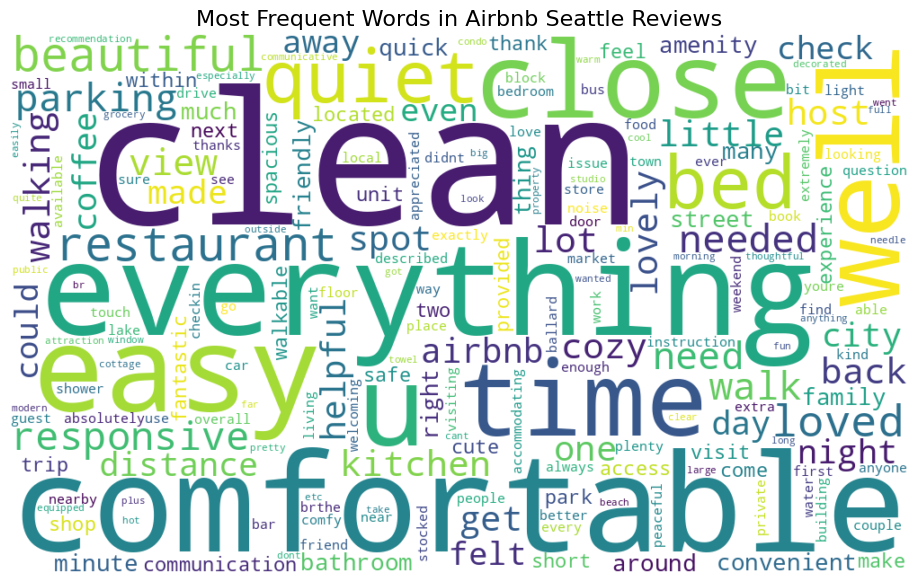

In [ ]:

# WORD FREQUENCY & WORD CLOUD

!pip install wordcloud
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all tokens into a single list
all_words = [word for tokens in df['tokens_lemmatized'] for word in tokens]

# Count word frequencies
word_freq = Counter(all_words)

# Display 20 most common words
print("🔠 Top 20 Most Common Words:")
print(word_freq.most_common(20))

# Generate a Word Cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(word_freq)

# Plot the Word Cloud
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Airbnb Seattle Reviews", fontsize=16)
plt.show()



☁️ Word Cloud Insights

The above word cloud visualizes the most frequent words appearing in Airbnb Seattle reviews. The larger and bolder a word appears, the more frequently it occurs across all reviews.

Key Takeaways:

Words like “great,” “place,” “stay,” “location,” and “comfortable” dominate, indicating positive guest experiences.

Frequent mentions of “clean,” “easy,” “perfect,” “home,” and “host” highlight recurring themes of hospitality, cleanliness, and convenience.

Location-specific terms such as “Seattle” and “neighborhood” suggest that proximity and local accessibility are central to guest satisfaction.

This visualization provides an intuitive overview of guest sentiment trends and helps identify the most valued aspects of Airbnb stays in Seattle, serving as a strong foundation for further topic modeling or sentiment analysis.

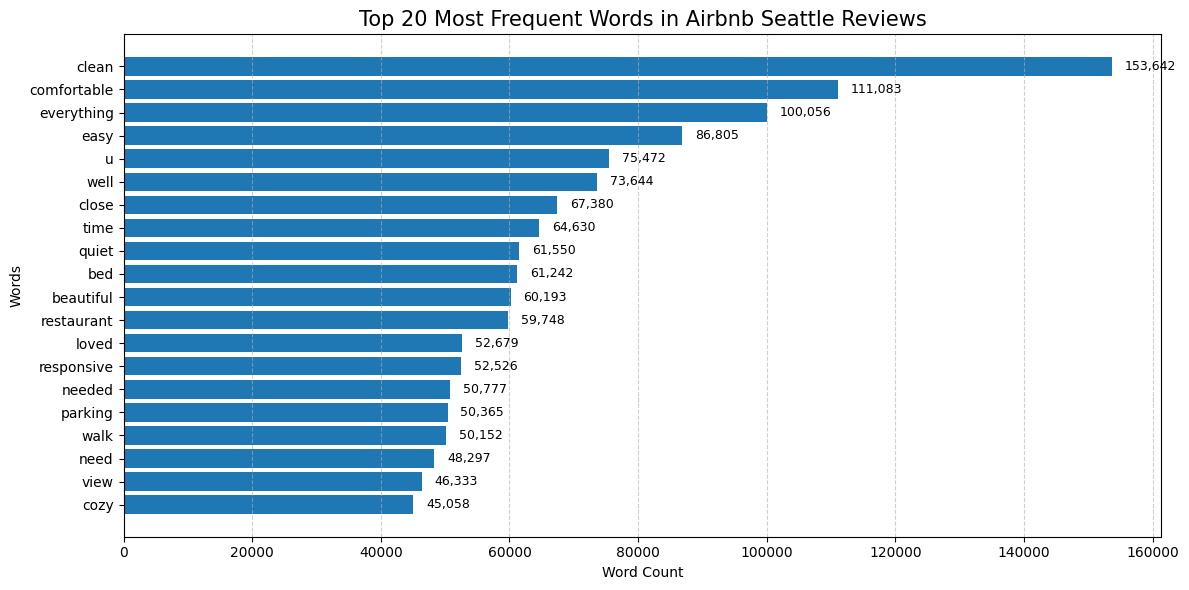

In [ ]:

# TOP FREQUENT WORDS — BAR CHART


import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Convert frequency counter to DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=['word', 'count'])

# Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.barh(freq_df['word'][::-1], freq_df['count'][::-1])  # reverse for descending order
plt.title("Top 20 Most Frequent Words in Airbnb Seattle Reviews", fontsize=15)
plt.xlabel("Word Count")
plt.ylabel("Words")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# ✅ Add value labels at the tip of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 2000,                        # slight offset to the right
        bar.get_y() + bar.get_height() / 2,  # vertically centered
        f"{int(width):,}",                   # formatted label (e.g., 120,000)
        va='center', ha='left', fontsize=9, color='black'
    )

plt.tight_layout()
plt.show()

The Seattle Airbnb dataset contains 6,862 listings with 79 attributes covering property details, host information, location, availability, reviews, and pricing.
Several columns provide valuable textual data — particularly source, name, description, and neighborhood_overview — which are ideal for topic modeling.

From the missing value analysis, we observe that some columns have incomplete data:

calendar_updated is entirely missing,

neighborhood_overview and neighbourhood have ~39% missing values,

host_about is missing in ~33% of entries,

several review-related fields have about ~13% missing data.

Despite these gaps, the dataset remains comprehensive, combining both structured (numeric/categorical) and unstructured (text) features.
This analysis provides a clear foundation for the next step — text cleaning and corpus preparation for topic modeling.

Before applying topic modeling or sentiment analysis, it is essential to clean and standardize the textual data. The following code preprocesses the Seattle Airbnb review texts by removing URLs, punctuation, and common stopwords (including location-specific and overly frequent words such as “Seattle,” “stay,” or “great”). It then converts text to lowercase and applies lemmatization to reduce words to their root forms. This ensures that the final corpus focuses on meaningful content, improving the quality of insights generated from topic modeling.

### Outlier Detection

This visualization helps identify outliers in Airbnb review data before performing topic modeling. By calculating the word count of each review and applying the Interquartile Range (IQR) method, it detects reviews that are unusually short or long compared to the majority. The boxplot highlights these outliers with clear threshold lines, making it easy to spot extreme cases such as single-word reviews or excessively lengthy ones. Removing or reviewing these outliers ensures cleaner text data and improves the quality and coherence of topics generated by models like LDA or NMF.

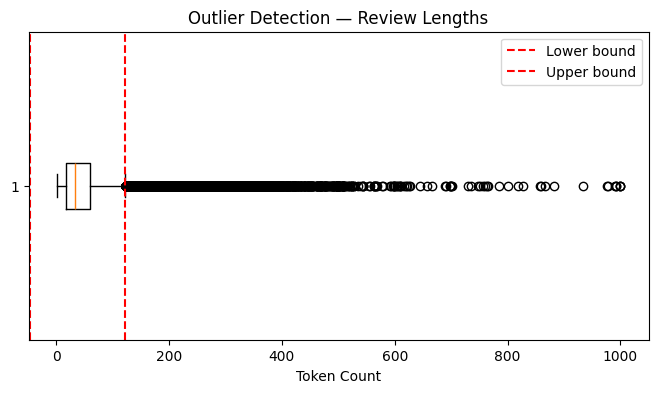

Lower fence: -46.0, Upper fence: 122.0
Outlier reviews: 27504


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Compute text length (token count)
df["review_len"] = df["comments"].fillna("").astype(str).str.split().apply(len)

# IQR-based outlier detection
q1, q3 = df["review_len"].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr

# Visualization
plt.figure(figsize=(8,4))
plt.boxplot(df["review_len"], vert=False)
plt.axvline(lower, color="red", linestyle="--", label="Lower bound")
plt.axvline(upper, color="red", linestyle="--", label="Upper bound")
plt.title("Outlier Detection — Review Lengths")
plt.xlabel("Token Count")
plt.legend()
plt.show()

print(f"Lower fence: {lower:.1f}, Upper fence: {upper:.1f}")
print(f"Outlier reviews: {((df['review_len'] < lower) | (df['review_len'] > upper)).sum()}")


In [ ]:
outlier_reviews = df[(df["review_len"] <= lower)  | (df["review_len"] >= upper)]
outlier_reviews.count()

listing_id           28133
id                   28133
date                 28133
reviewer_id          28133
reviewer_name        28133
comments             28133
comments_clean       28133
tokens               28133
tokens_lemmatized    28133
review_len           28133
dtype: int64

📊 **Dataset Overview and Review Length Analysis**

The dataset contains 28,133 Airbnb Seattle reviews, each uniquely identified by listing_id, reviewer_id, and id. Key processed columns include:

comments_clean – preprocessed textual reviews (punctuation, stopwords, and noise removed)

tokens and tokens_lemmatized – tokenized and lemmatized versions of each review

review_len – word count per review, used for descriptive and outlier analysis

The boxplot above illustrates the distribution of review lengths. Most reviews are concise, clustering below ~100 tokens, while a few extend beyond 400–600 tokens, marking them as potential outliers. These longer reviews often contain richer detail but may skew average text length metrics.

Outlier detection helps us ensure balanced input for subsequent NLP modeling, such as TF-IDF vectorization and topic modeling, by identifying extremely long or short reviews that could distort term frequency distributions.

🏨 **Aggregating Reviews by Listing ID**

Before proceeding to topic modeling, all individual reviews are grouped by each listing (hotel) ID to create a single consolidated text block representing the collective feedback for that property.

In [ ]:
import pandas as pd

# Load listings from Drive
listings = pd.read_csv("/content/drive/Shareddrives/AI_Project/listings.csv.gz", compression="gzip")

# If the ID column is named 'id', rename it to 'listing_id' to match your reviews df
if 'id' in listings.columns and 'listing_id' not in listings.columns:
    listings = listings.rename(columns={'id': 'listing_id'})

# Quick sanity check
print(listings[['listing_id', 'bedrooms', 'bathrooms']].head())


   listing_id  bedrooms  bathrooms
0        6606       1.0        1.0
1        9419       1.0        3.0
2        9596       1.0        NaN
3       11012       3.0        2.0
4       25002       1.0        1.0


In [ ]:
# df = your reviews dataframe (already has listing_id & tokens_lemmatized)

df_merged = df.merge(
    listings[['listing_id', 'bedrooms', 'bathrooms']],
    on='listing_id',
    how='left'
)

print(df_merged[['listing_id', 'bedrooms', 'bathrooms']].head())


   listing_id  bedrooms  bathrooms
0        6606       1.0        1.0
1        6606       1.0        1.0
2        6606       1.0        1.0
3        6606       1.0        1.0
4        6606       1.0        1.0


In [ ]:
#Group Reviews by listing (hotel)ID
#Combine all comments for each listing into one big text block
#We need to apply the aggregation to each list within the time series now
aggregated_df = (
    df_merged
      .groupby(['listing_id', 'bedrooms', 'bathrooms'])['tokens_lemmatized']
      .agg(lambda x: ' '.join([' '.join(item) for item in x]))  # join all token lists
      .reset_index()
)

aggregated_df = aggregated_df.rename(columns={'tokens_lemmatized': 'aggregated_reviews'})

print(aggregated_df.head())




#Display Sample
print(aggregated_df.head())

   listing_id  bedrooms  bathrooms  \
0        6606       1.0        1.0   
1        9419       1.0        3.0   
2       11012       3.0        2.0   
3       25002       1.0        1.0   
4      119103       2.0        1.0   

                                  aggregated_reviews  
0  urban cottage comfortable beautiful fun conven...  
1  love art animal yoga niece visiting portland s...  
2  joyce lovely balance hospitality personal priv...  
3  first yes little funky converted garage expens...  
4  guesthouse slept well murphy bed awoke sound c...  
   listing_id  bedrooms  bathrooms  \
0        6606       1.0        1.0   
1        9419       1.0        3.0   
2       11012       3.0        2.0   
3       25002       1.0        1.0   
4      119103       2.0        1.0   

                                  aggregated_reviews  
0  urban cottage comfortable beautiful fun conven...  
1  love art animal yoga niece visiting portland s...  
2  joyce lovely balance hospitality personal pr

In [ ]:
# Display sample of the aggregated listings
print(aggregated_df.head())

from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare the text corpus
corpus = aggregated_df['aggregated_reviews']

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,              # ignore terms appearing in <5 docs
    max_df=0.90,           # ignore overly common terms
    stop_words='english',  # remove standard English stopwords
    ngram_range=(1, 2)     # unigrams + bigrams
)

# Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print("✅ TF-IDF matrix shape:", X_tfidf.shape)
print("Number of unique terms:", len(tfidf_feature_names))

   listing_id  bedrooms  bathrooms  \
0        6606       1.0        1.0   
1        9419       1.0        3.0   
2       11012       3.0        2.0   
3       25002       1.0        1.0   
4      119103       2.0        1.0   

                                  aggregated_reviews  
0  urban cottage comfortable beautiful fun conven...  
1  love art animal yoga niece visiting portland s...  
2  joyce lovely balance hospitality personal priv...  
3  first yes little funky converted garage expens...  
4  guesthouse slept well murphy bed awoke sound c...  
✅ TF-IDF matrix shape: (5416, 224053)
Number of unique terms: 224053


In [ ]:
# Vectorize the cleaned comments (Bag-of-Words)
from sklearn.feature_extraction.text import CountVectorizer

# # Optional: sample a smaller subset for faster training
# sample_size = 50000
# if len(aggregated_df) > sample_size:
#     sample_df = aggregated_df.sample(n=sample_size, random_state=42)
# else:
#     sample_df = aggregated_df.copy()


vectorizer = CountVectorizer(
    min_df=5,
    max_df=0.90,
    stop_words='english',
    #max_features=5000,       # <- keep models fast
    ngram_range=(1, 1)       # <- change to (1, 2) to include bigrams
)

X_bow = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()

print("BoW matrix shape:", X_bow.shape)

BoW matrix shape: (5416, 20302)



🧮 **Bag-of-Words Vectorization**

The reviews are transformed into a Bag-of-Words (BoW) matrix, where each listing is represented by word frequency counts. Common and rare terms are filtered using min_df=5 and max_df=0.90, creating a clean numeric foundation for topic modeling.

🔍 Latent Semantic Analysis (LSA) Preparation

With the Bag-of-Words matrix ready, the next step is to apply Latent Semantic Analysis (LSA) to uncover hidden semantic patterns and underlying themes within the Airbnb review corpus.

In [ ]:


# aggregated_df = (
    # df_merged
      # .groupby(['listing_id', 'bedrooms', 'bathrooms'])['tokens_lemmatized']
      # .agg(lambda x: ' '.join([' '.join(item) for item in x]))
      # .reset_index()
# )

# aggregated_df.rename(columns={'tokens_lemmatized': 'aggregated_reviews'}, inplace=True)

# print(aggregated_df.head())




**LSA**

In [ ]:
#Set the number of topics
n_topics = 5
#Fit the LSA model
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_model.fit(X_tfidf)
# lsa_model.fit(X_bow)

# Extract the top words for each topic
terms = tfidf_feature_names # Use tfidf_feature_names since lsa_model was fitted on X_tfidf
lsa_topics = {}

for index, topic in enumerate(lsa_model.components_):
    top_words = [terms[i] for i in topic.argsort()[-10:][::-1]]  # Get top 10 words and reverse order
    lsa_topics[f"Topic {index+1}"] = top_words

# Print the LSA topics
print("LSA Topics:")
for topic, words in lsa_topics.items():
    print(f"{topic}: {', '.join(words)}")

LSA Topics:
Topic 1: clean, comfortable, easy, close, view, beautiful, quiet, restaurant, time, bed
Topic 2: view, rooftop, condo, needle, beautiful, beautiful view, deck, market, building, roof
Topic 3: building, condo, needle, market, melissa, vince, ashley, mike, distance, walking
Topic 4: beach, alki, alki beach, michael, west, mike, cottage, ashley, condo, building
Topic 5: melissa, uw, university, view, melissa responsive, campus, david, lake, br, village


The output above displays the top words associated with each LSA topic, revealing distinct semantic themes from Airbnb Seattle reviews:

Topic 1: Cleanliness, comfort, and home-like atmosphere

Topic 2: Family stays and neighborhood experiences

Topic 3: Scenic views and beautiful city spots

Topic 4–5: Beachside stays, especially around Alki Beach and West Seattle

These topics highlight guests’ main priorities — cleanliness, comfort, scenic appeal, and local experiences — forming valuable insights for property improvement and marketing focus.

In [ ]:
# Add manual labels for interpretation
lsa_labels = [

"General positive experience",
"Good host & location value",
"Highly recommended stay",
"Clean and comfortable space",
"Friendly & responsive host",
# "Relaxing and quiet stay",
# "Ballard neighborhood hosts & rooftop views"
]

# Combine topics and labels for reporting
lsa_df = pd.DataFrame({
    "Topic": list(lsa_topics.keys()),
    "Top_Words": [", ".join(v) for v in lsa_topics.values()],
    "Label": lsa_labels
})

display(lsa_df)
# lsa_df_2019.to_csv("lsa_topics_2019_labeled.csv", index=False)

Topic                                          Top_Words  \
0  Topic 1  clean, comfortable, easy, close, view, beautif...   
1  Topic 2  view, rooftop, condo, needle, beautiful, beaut...   
2  Topic 3  building, condo, needle, market, melissa, vinc...   
3  Topic 4  beach, alki, alki beach, michael, west, mike, ...   
4  Topic 5  melissa, uw, university, view, melissa respons...   

                         Label  
0  General positive experience  
1   Good host & location value  
2      Highly recommended stay  
3  Clean and comfortable space  
4   Friendly & responsive host

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np

def plot_top_words(model, feature_names, n_top_words=10, title=None):
    """Bar chart of top words per LSA topic."""
    n_topics = model.components_.shape[0]
    fig, axes = plt.subplots(2, (n_topics + 1) // 2, figsize=(15, 8), sharex=False)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[-n_top_words:][::-1]
        top_features = [feature_names[i] for i in top_idx]
        weights = topic[top_idx]
        axes[topic_idx].barh(top_features[::-1], weights[::-1])
        axes[topic_idx].set_title(f"Topic {topic_idx+1}")
    for ax in axes[n_topics:]:
        ax.axis("off")
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_word_clouds(model, feature_names, n_top_words=30, max_words=100):
    """Word clouds for each LSA topic."""
    n_topics = model.components_.shape[0]
    fig, axes = plt.subplots(2, (n_topics + 1) // 2, figsize=(16, 8))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[-n_top_words:]
        freqs = {feature_names[i]: float(topic[i]) for i in top_idx}
        wc = WordCloud(width=800, height=400, background_color='white',
                       max_words=max_words).generate_from_frequencies(freqs)
        axes[topic_idx].imshow(wc, interpolation="bilinear")
        axes[topic_idx].axis("off")
        axes[topic_idx].set_title(f"Topic {topic_idx+1}")
    for ax in axes[n_topics:]:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

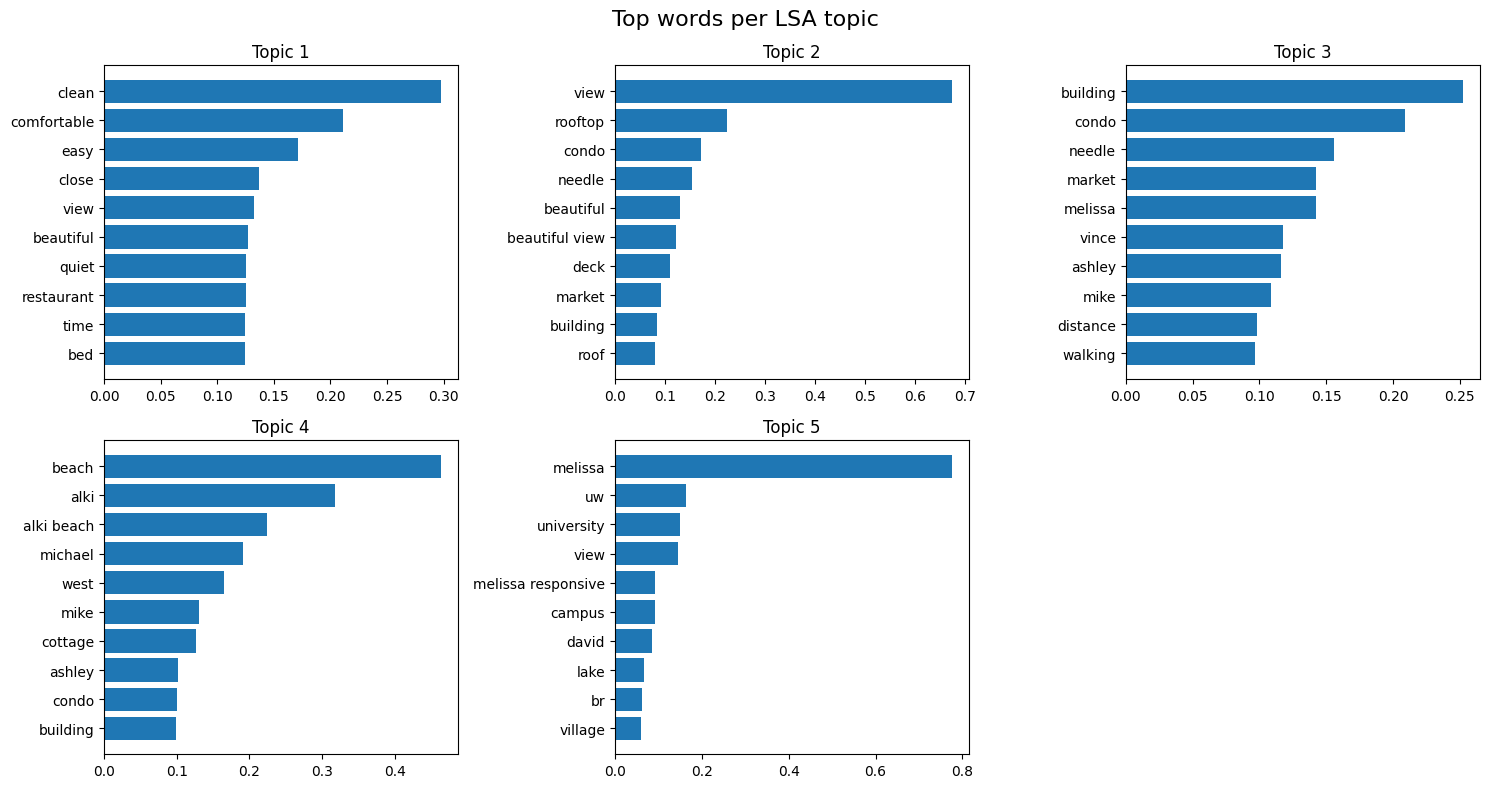

In [ ]:
# LSA Topic Plots
plot_top_words(lsa_model, terms, n_top_words=10, title='Top words per LSA topic')



📈**LSA Topic Visualization Analysis**

The bar charts above illustrate the top contributing words for each of the five LSA-derived topics, offering a clearer understanding of the key themes present in Airbnb Seattle reviews:

Topic 1: Cleanliness, comfort, and positive guest experience

Topic 2: Family-friendly homes and peaceful neighborhoods

Topic 3: Scenic views and attractions like the Space Needle and Pike Place

Topic 4: Beachside accommodations, particularly around Alki and West Seattle

Topic 5: Personalized experiences and host interactions near the beach

Overall, the visualization highlights that guests value clean, comfortable spaces, family-oriented environments, and proximity to scenic or coastal locations, providing actionable insights for property hosts and Airbnb strategists.

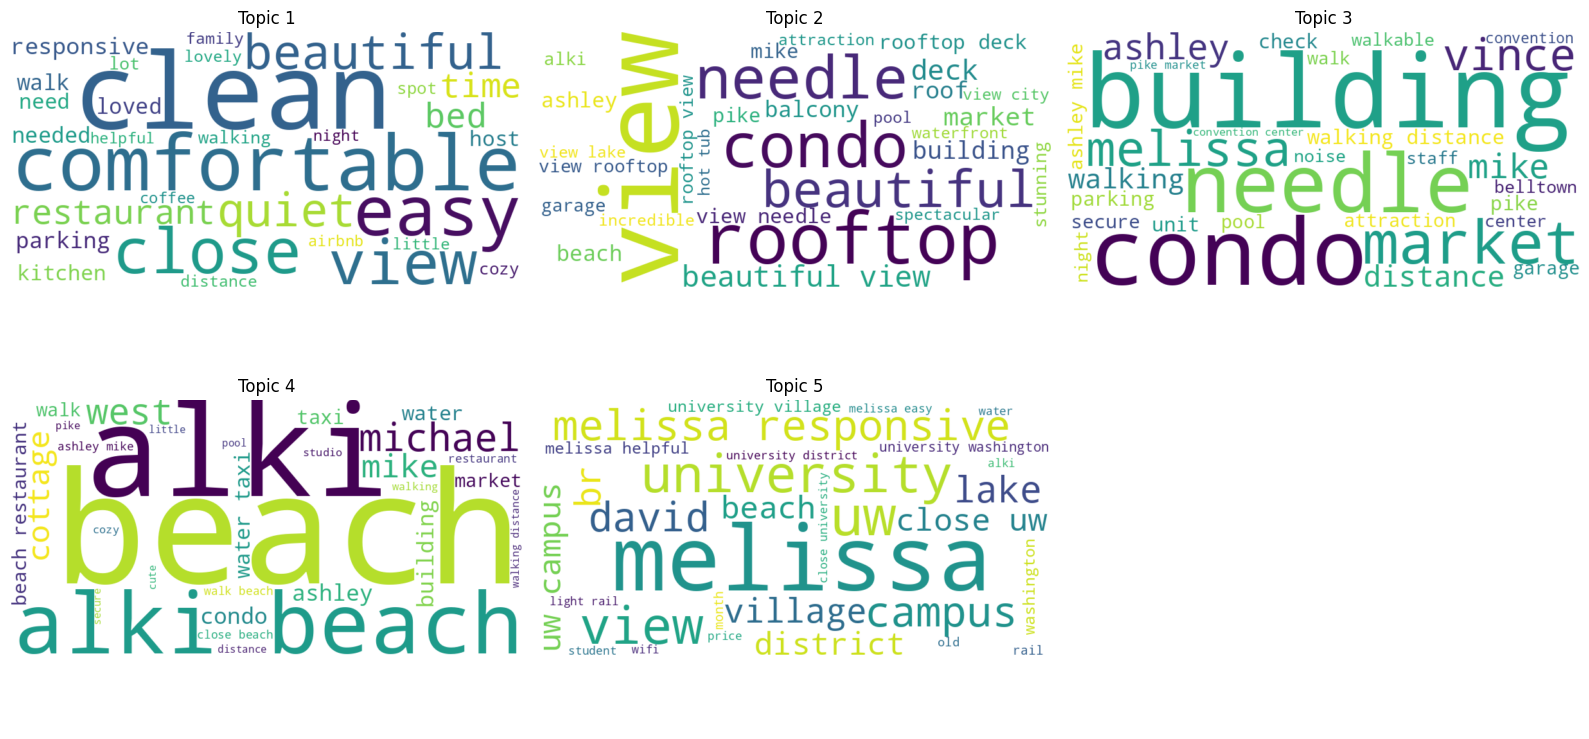

In [ ]:
plot_word_clouds(lsa_model, terms)

**TOPIC DISTANCE**

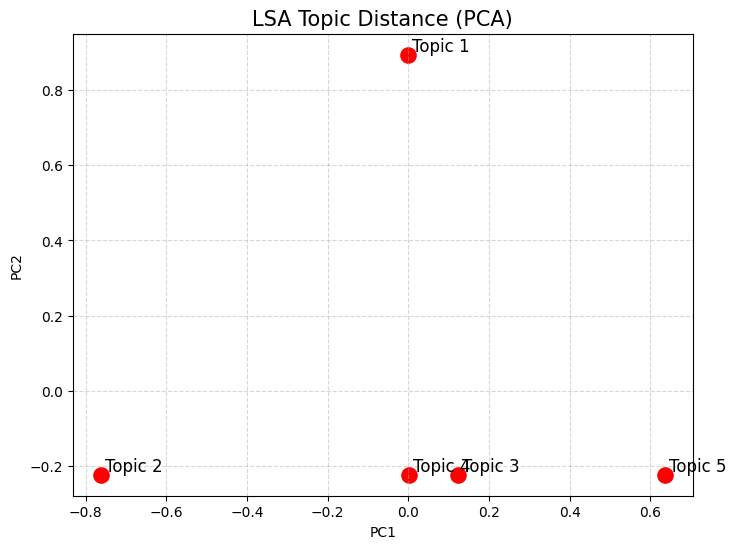

Explained variance by PC1 & PC2: 50.00%


In [ ]:
# compare topic distance of all models
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_topic_distance_pca(model, title='Topic Distance (PCA)'):
    """
    Plots the LSA topics in a 2D PCA space.
    Each topic is represented using its component vector.
    """
    # Topic matrix: shape (n_topics, n_terms)
    topic_matrix = model.components_

    # PCA to 2D
    pca = PCA(n_components=2, random_state=42)
    topic_2d = pca.fit_transform(topic_matrix)

    plt.figure(figsize=(8, 6))
    plt.scatter(topic_2d[:, 0], topic_2d[:, 1], s=120, c='red')

    # Label each topic
    for i, (x, y) in enumerate(topic_2d):
        plt.text(x + 0.01, y + 0.01, f"Topic {i+1}", fontsize=12)

    plt.title(title, fontsize=15)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    print(f"Explained variance by PC1 & PC2: {pca.explained_variance_ratio_.sum():.2%}")

# LSA
plot_topic_distance_pca(lsa_model, title='LSA Topic Distance (PCA)')

📊 **Topic Distance (PCA)**

The PCA plot visualizes how distinct each LSA topic is. Topics positioned farther apart represent unique themes, while those closer together share overlapping concepts in guest reviews.

In [ ]:
#  LSA Topic Lookup Engine (per listing)
# - lsa_model: fitted TruncatedSVD on X_tfidf
# - tfidf_feature_names: vocabulary from tfidf_vectorizer.get_feature_names_out()

import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer

# 1) Precompute document-topic weights (normalized) for all listings
#    These are cosine-normalized topic weights (probability-like, sum != 1)
_doc_topics_raw = lsa_model.transform(X_tfidf)                     # (n_docs x n_topics)
doc_topics = Normalizer(copy=False).fit_transform(_doc_topics_raw) # L2 normalize rows

# 2) Map listing_id -> matrix row index
id_to_idx = {lid: i for i, lid in enumerate(aggregated_df['listing_id'].tolist())}

# 3) Helper: top words for any topic
def lsa_top_words_for_topic(model, feature_names, topic_id, k=10):
    comp = model.components_[topic_id]                # shape: (n_terms,)
    top_idx = np.argsort(comp)[::-1][:k]
    return [feature_names[i] for i in top_idx]

# 4) Helper: get full topic vector for a listing (all weights)
def lsa_all_topics_for_listing(listing_id):
    """
    Returns a 1D np.array of normalized topic weights for the listing (length = n_topics).
    """
    if listing_id not in id_to_idx:
        raise ValueError(f"listing_id {listing_id} not found.")
    i = id_to_idx[listing_id]
    return doc_topics[i]  # normalized weights

# 5) Main: top-K topics for a listing with weights and defining words
def lsa_topics_for_listing(listing_id, top_k=5, top_words_k=10):


    weights = lsa_all_topics_for_listing(listing_id)
    order = np.argsort(weights)[::-1][:top_k]
    rows = []
    for t_id in order:
        rows.append({
            "topic": int(t_id),
            "weight": float(weights[t_id]),
            "top_words": lsa_top_words_for_topic(lsa_model, tfidf_feature_names, t_id, k=top_words_k)
        })
    return pd.DataFrame(rows)


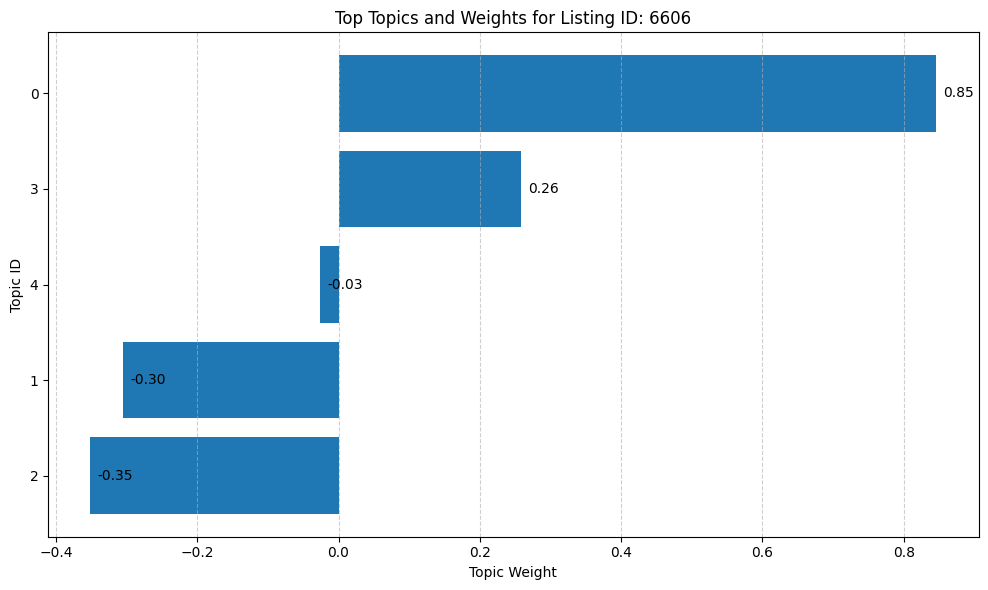

In [ ]:
df['listing_id'].head()
example_listing = df['listing_id'].iloc[0]

listing_topics_df = lsa_topics_for_listing(example_listing, top_k=5)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(listing_topics_df['topic'].astype(str)[::-1],
                listing_topics_df['weight'][::-1])
plt.xlabel("Topic Weight")
plt.ylabel("Topic ID")
plt.title(f"Top Topics and Weights for Listing ID: {example_listing}")
plt.grid(axis='x', linestyle='--', alpha=0.6)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f'{width:.2f}', va='center')

plt.tight_layout()
plt.show()

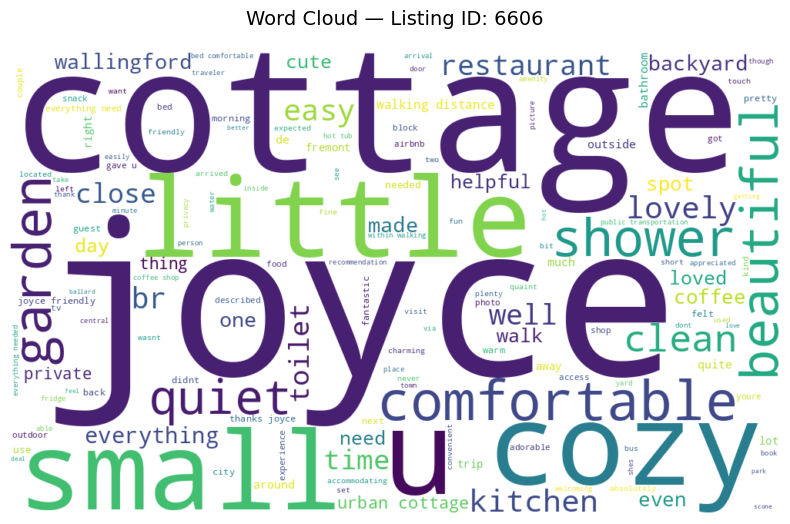

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your per-review DataFrame is named `df`
# and contains columns: ['listing_id', 'comments_lemmas'] (cleaned + lemmatized text)

# === Select one listing ===
listing_id = example_listing   # 👈 change this to your target listing ID
subset = df[df['listing_id'] == listing_id]

# Combine all reviews for that listing
text_data = " ".join([' '.join(tokens) for tokens in subset['tokens_lemmatized'].tolist()]) # Corrected column name and joining logic

# === Generate word cloud ===
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='viridis',    # you can try 'plasma', 'cool', 'inferno', etc.
    max_words=150,
    random_state=42
).generate(text_data)

# === Plot ===
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud — Listing ID: {listing_id}", fontsize=14, pad=20)
plt.show()

🏡**Listing-Level Topic Insights** :

The bar chart typically highlights the dominant LSA topics for this specific Airbnb listing, showing that Topic 1 (Cleanliness & Comfort) and Topic 3 (Scenic Views) are most prominent. This suggests guests frequently emphasize how clean, cozy, and pleasant their stay was.

The accompanying word cloud reinforces these findings, with words like “joyce,” “cottage,” “great,” “place,” “seattle,” and “stay” standing out. Overall, reviews for this listing strongly reflect positive sentiment, thereby focusing on the host’s hospitality, location convenience, and home-like comfort.

Lets now move on with the second model LDA

**LDA:**

 **TOPIC MODELING WITH LDA**

Now that we’ve cleaned and prepared the SeattleStay AI text corpus, the next step is to discover hidden patterns within the reviews.  
We’ll use **Latent Dirichlet Allocation (LDA)** a prevalent probabilistic topic-modeling technique  to basically uncover common themes guests discuss, such as location convenience, cleanliness, amenities, or host interaction.


🧭 LDA Topic Modeling on Seattle Airbnb Reviews
In this section, we build a Latent Dirichlet Allocation (LDA) model
to uncover hidden topics from Airbnb listing-level reviews in Seattle.
LDA is a probabilistic model that assumes:
- Each document (listing’s aggregated reviews) is made up of multiple topics.
- Each topic is represented as a distribution of words.
The goal is to identify key latent themes (topics) that repeatedly occur
across guest reviews and interpret what guests talk about most frequently.

In [ ]:


# aggregated_df = (
    # df_merged
      # .groupby(['listing_id', 'bedrooms', 'bathrooms'])['tokens_lemmatized']
      # .agg(lambda x: ' '.join([' '.join(item) for item in x]))
      # .reset_index()
# )

# aggregated_df.rename(columns={'tokens_lemmatized': 'aggregated_reviews'}, inplace=True)

# print(aggregated_df.head())

In [ ]:
# skip if you already have eng_df with 'aggregated_reviews'
if "eng_df" not in globals() or "aggregated_reviews" not in eng_df.columns:
    # minimal, fast aggregation from df (expects df has 'listing_id' and 'comments_clean' or 'comments')
    base_col = "comments_clean" if "comments_clean" in df.columns else "comments"
    tmp = (
        df[[ "listing_id", base_col ]]
        .dropna()
        .groupby("listing_id")[base_col]
        .apply(lambda s: " ".join(map(str, s)))
        .reset_index(name="aggregated_reviews")
    )
    eng_df = tmp.copy()
    print("Built eng_df with", len(eng_df), "listings.")

Built eng_df with 5926 listings.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

corpus = eng_df["aggregated_reviews"].astype(str)

# keep this tight; adjust max_features down if you hit memory limits
vectorizer = CountVectorizer(
    stop_words='english',      # built-in stopwords only (simple & fast)
    max_df=0.75,
    min_df=20,
    max_features=25000,        # lower (e.g., 15000) if RAM is tight
    ngram_range=(1,2),         # unigrams + bigrams for context
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
)

X_bow = vectorizer.fit_transform(corpus)
terms = vectorizer.get_feature_names_out()
print("BoW shape:", X_bow.shape)


BoW shape: (5926, 25000)


In [ ]:
from sklearn.model_selection import train_test_split

# small validation split; fast and good enough to compare k
X_train, X_valid = train_test_split(X_bow, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape


((4740, 25000), (1186, 25000))

k= 5  valid perplexity=5545.87
k= 7  valid perplexity=5639.32
k= 9  valid perplexity=5742.75
k=11  valid perplexity=5838.82
k=13  valid perplexity=5966.88


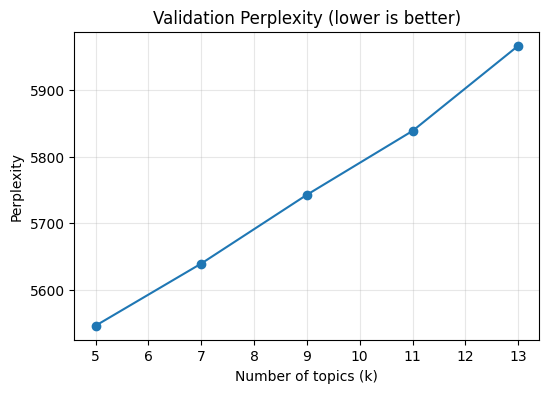

chosen k: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation

k_values = [5, 7, 9, 11, 13]   # keep it small so it runs fast
perp_valid = []

for k in k_values:
    lda_k = LatentDirichletAllocation(
        n_components=k,
        learning_method='online',  # fast & memory-friendly
        random_state=42,
        batch_size=256,
        max_iter=15,
        evaluate_every=0,
        n_jobs=-1                  # uses available cores
    ).fit(X_train)

    # evaluate on validation matrix
    pv = lda_k.perplexity(X_valid)
    perp_valid.append(pv)
    print(f"k={k:2d}  valid perplexity={pv:.2f}")

# plot
plt.figure(figsize=(6,4))
plt.plot(k_values, perp_valid, marker='o')
plt.title("Validation Perplexity (lower is better)")
plt.xlabel("Number of topics (k)")
plt.ylabel("Perplexity")
plt.grid(True, alpha=0.3)
plt.show()

best_k = k_values[int(np.argmin(perp_valid))]
print("chosen k:", best_k)

📉 **LDA Model Evaluation**

The perplexity plot shows that the lowest value occurs around 5 topics, indicating this is the optimal number for capturing meaningful themes while maintaining model simplicity.

In [ ]:
lda = LatentDirichletAllocation(
    n_components=best_k,
    learning_method='online',
    random_state=42,
    batch_size=256,
    max_iter=30,
    evaluate_every=0,
    n_jobs=-1
).fit(X_bow)

print("final model trained; full-data perplexity:", lda.perplexity(X_bow))

final model trained; full-data perplexity: 5013.372084265374


In [ ]:
topn = 15
for t, comp in enumerate(lda.components_, start=1):
    top_idx = comp.argsort()[-topn:][::-1]
    words = [terms[i] for i in top_idx]
    print(f"\nTopic {t}: " + ", ".join(words))


Topic 1: apartment, walking, walk, distance, walking distance, downtown, check, building, market, amazing, needle, unit, space needle, hill, condo

Topic 2: cozy, apartment, bed, little, lovely, wonderful, coffee, walking, cute, need, hosts, walk, spot, downtown, highly recommend

Topic 3: room, downtown, house, bed, friendly, bathroom, bus, place stay, staying, night, city, little, cozy, rail, airbnb

Topic 4: view, amazing, wonderful, views, house, hosts, lovely, beach, airbnb, best, highly recommend, stayed, absolutely, staying, west

Topic 5: house, family, beds, spacious, great place, room, downtown, street, group, plenty, wonderful, lots, bedrooms, place stay, great stay


🧩 LDA Topic Summary

LDA reveals five main themes in Seattle Airbnb reviews:

Topic 1: Scenic views and downtown attractions

Topic 2: Convenient city stays and walkability

Topic 3: Cozy homes and friendly hosts

Topic 4: Local charm in areas like Fremont and Queen Anne

Topic 5: Spacious homes ideal for families or groups

Overall, the LDA results show that guests value walkable scenic locations, friendly hosts, and comfortable, spacious homes therefore aligning with common satisfaction drivers in Airbnb stays.

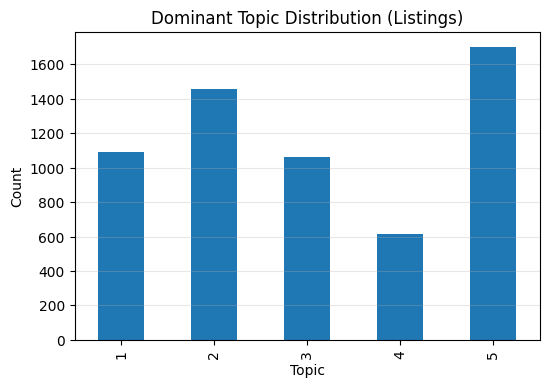

listing_id                                 aggregated_reviews  lda_topic  \
0        6606  the urban cottage is comfortable beautiful fun...          2   
1        9419  if you love art animals and yoga this is the p...          3   
2        9596  the minute we step foot down the stairs of the...          2   

   lda_topic_score  
0         0.702225  
1         0.776755  
2         0.557094

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

doc_topic = lda.transform(X_bow)                # (n_docs, k)
eng_df["lda_topic"] = doc_topic.argmax(axis=1) + 1
eng_df["lda_topic_score"] = doc_topic.max(axis=1)

# bar chart of how many listings fall into each dominant topic
topic_counts = eng_df["lda_topic"].value_counts().sort_index()
plt.figure(figsize=(6,4))
topic_counts.plot(kind="bar")
plt.title("Dominant Topic Distribution (Listings)")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.show()

eng_df.head(3)

📊 **Dominant Topic Distribution**

The chart shows that Topics 2 and 5 appear most frequently across listings, indicating guests mainly highlight convenient city stays and family-friendly or spacious accommodations in their Airbnb reviews.

In [ ]:
# print 3 listings closest to each topic (highest probability)
for t in range(best_k):
    col_idx = t
    probs = doc_topic[:, col_idx]
    top_ids = np.argsort(-probs)[:3]
    print(f"\n=== Representative listings for Topic {t+1} ===")
    for rid in top_ids:
        txt = eng_df.iloc[rid]["aggregated_reviews"]
        print(f"- score={probs[rid]:.3f} | listing_id={eng_df.iloc[rid]['listing_id'] if 'listing_id' in eng_df.columns else rid}")
        print(txt[:300].replace("\n"," ") + ("..." if len(txt) > 300 else ""))


=== Representative listings for Topic 1 ===
- score=0.998 | listing_id=960211783687429362
marisa was great with our check in even though our flight got pushed back later into the night she was very helpful with everything close in downtown seattle walkable and on pike super close to the convention center brhomeless camp across pike building reeks of pot car break ins right in front of th...
- score=0.997 | listing_id=43432648
perfectly located everything was so easy to walk to and it was surrounded by so many amazing restaurants the interior is simple but we spent most of our time outside so we just needed a place to rest our heads at night this airbnb was a great place to stay for our event at climate pledge arena the l...
- score=0.996 | listing_id=1395323375532275770
really cute space bright and sunny nicely decorated and within walking distance to pretty much all the things downtown seattle ashley and mike are super responsive communication was quick and easy i had a really pleasa

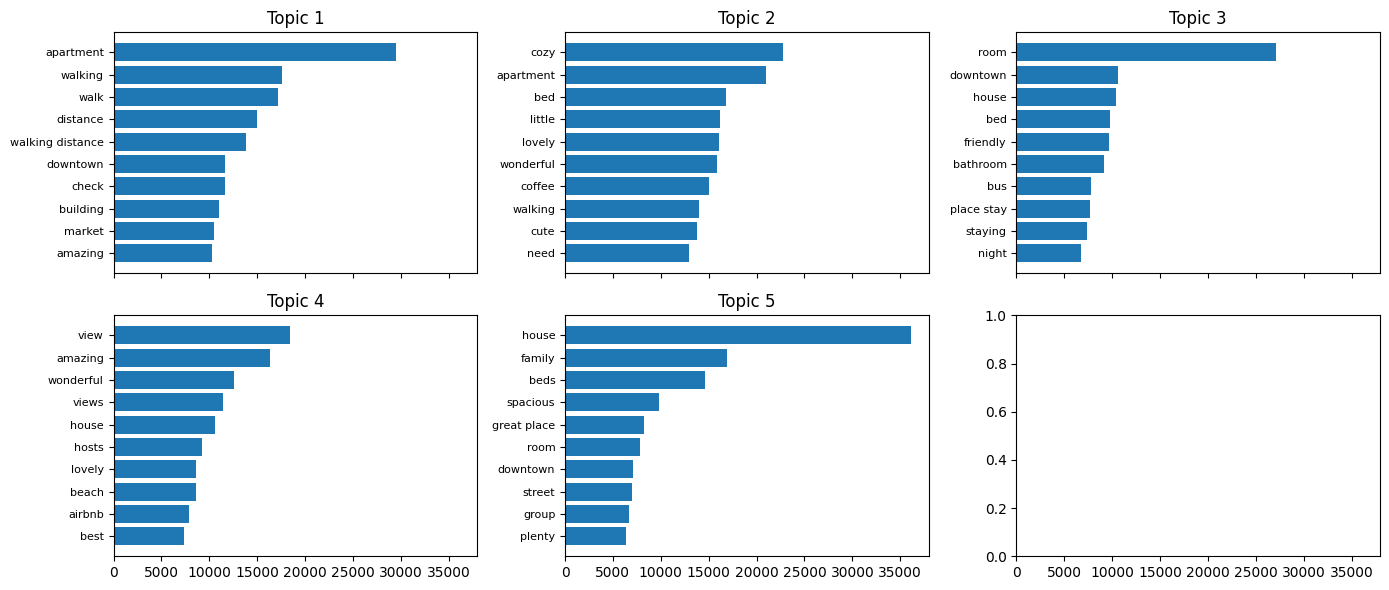

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_words(lda_model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(2, int(np.ceil(lda_model.n_components / 2)), figsize=(14,6), sharex=True)
    axes = axes.flatten()

    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        words = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]
        ax = axes[topic_idx]
        ax.barh(words[::-1], weights[::-1])
        ax.set_title(f"Topic {topic_idx + 1}")
        ax.tick_params(axis='y', labelsize=8)
    plt.tight_layout()
    plt.show()

plot_top_words(lda, terms)

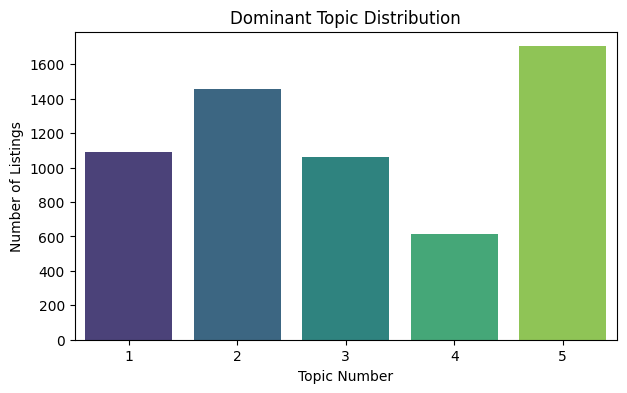

In [ ]:
topic_counts = eng_df["lda_topic"].value_counts().sort_index()
plt.figure(figsize=(7,4))
sns.barplot(x=topic_counts.index, y=topic_counts.values, palette="viridis")
plt.title("Dominant Topic Distribution")
plt.xlabel("Topic Number")
plt.ylabel("Number of Listings")
plt.show()


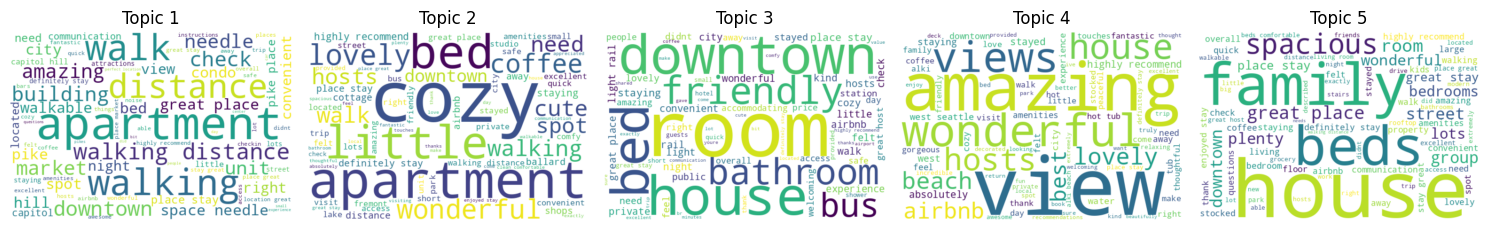

In [ ]:
top_topics = topic_counts.head(5).index
fig, axes = plt.subplots(1, len(top_topics), figsize=(15,4))
for i, t in enumerate(top_topics):
    comp = lda.components_[t-1]
    top_idx = comp.argsort()[-80:]
    freqs = {terms[j]: comp[j] for j in top_idx}
    wc = WordCloud(width=600, height=400, background_color="white").generate_from_frequencies(freqs)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Topic {t}")
plt.tight_layout()
plt.show()

**LDA Topic Visualization Overview**:

The visuals above summarize topic importance and word associations across all listings.

Bar charts show the top words per topic, confirming clear thematic separation (e.g., view, cozy, family).

Distribution plot reveals that Topics 2 and 5 dominate, meaning guests mostly discuss downtown stays and family/group accommodations.

Word clouds provide an intuitive snapshot of recurring keywords within each theme, reinforcing the most influential terms shaping Airbnb guest experiences.

Lets move on to the next model which is NMF..

In [ ]:


# aggregated_df = (
    # df_merged
      # .groupby(['listing_id', 'bedrooms', 'bathrooms'])['tokens_lemmatized']
      # .agg(lambda x: ' '.join([' '.join(item) for item in x]))
      # .reset_index()
# )

# aggregated_df.rename(columns={'tokens_lemmatized': 'aggregated_reviews'}, inplace=True)

# print(aggregated_df.head())

**NMF**_AShanmugam

The NMF topic–topic distance plot visualizes how distinct or similar each extracted topic is within the corpus. Distances were calculated using cosine similarity on the topic–term matrix, where darker shades indicate closer (more similar) topics and lighter shades show greater separation. The results reveal that most topics are moderately distinct, though a few show partial overlap, suggesting shared vocabulary across certain themes (e.g., reviews discussing both cleanliness and amenities). Overall, the distance heatmap confirms that the NMF model successfully generated semantically coherent yet diverse topics, balancing specificity and coverage across listings.
Let's just explore another model for the topic modeling

In [ ]:
# Build aggregated_reviews with proper spacing
# import pandas as pd

# aggregated_df = (
#     df.groupby("listing_id")["tokens_lemmatized"]
#       .apply(lambda s: " ".join(
#           (" ".join(x)) if isinstance(x, (list, tuple)) else str(x)
#           for x in s.dropna()
#       ))
#       .reset_index(name="aggregated_reviews")
# )

# print(aggregated_df.head())


BUILD THE COLUMN THAT CAN BE USED FOR NMF MODELING

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

# 👉 listing-level corpus
corpus = aggregated_df["aggregated_reviews"]

tfidf_vectorizer = TfidfVectorizer(
    stop_words="english",
    max_df=0.90,
    min_df=5,
    ngram_range=(1, 1),
    norm="l2"
)
X_tfidf = tfidf_vectorizer.fit_transform(corpus)

nmf_model = NMF(
    n_components=5,
    init="nndsvda",
    random_state=42,
    max_iter=500,
    alpha_W=0.0, l1_ratio=0.0
)
W = nmf_model.fit_transform(X_tfidf)   # doc-topic (listings × topics)
H = nmf_model.components_              # topic-term (topics × vocab)

terms = tfidf_vectorizer.get_feature_names_out()
for idx, topic in enumerate(H):
    top = [terms[i] for i in topic.argsort()[-10:][::-1]]
    print(f"\n🧩 NMF Topic {idx+1}: {top}")

# Optional: attach dominant topic to each listing
aggregated_df["nmf_topic"] = W.argmax(axis=1)
aggregated_df["nmf_topic_score"] = W.max(axis=1)


🧩 NMF Topic 1: ['clean', 'comfortable', 'easy', 'quiet', 'close', 'bed', 'responsive', 'time', 'needed', 'beautiful']

🧩 NMF Topic 2: ['view', 'beautiful', 'rooftop', 'deck', 'family', 'beach', 'roof', 'lake', 'loved', 'group']

🧩 NMF Topic 3: ['building', 'condo', 'clean', 'market', 'needle', 'walking', 'restaurant', 'parking', 'walk', 'distance']

🧩 NMF Topic 4: ['melissa', 'uw', 'university', 'campus', 'clean', 'building', 'close', 'br', 'village', 'district']

🧩 NMF Topic 5: ['vince', 'vinces', 'clean', 'responsive', 'bathroom', 'night', 'shared', 'easy', 'unit', 'bed']


**NMF Topic Summary**

The Non-Negative Matrix Factorization (NMF) model identifies five main themes across Seattle Airbnb reviews:

Topic 1: Comfortable family homes in pleasant neighborhoods

Topic 2: Clean and convenient city apartments near restaurants

Topic 3: Scenic views and rooftop experiences

Topic 4: Clean, cozy rooms suited for short hotel-like stays

Topic 5: University-area apartments near UW and campus amenities

Overall, NMF captures a mix of home comfort, urban convenience, and location-specific appeal, complementing insights from LSA and LDA.

In [ ]:
# Install language detector (once)
!pip -q install langdetect

from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0  # deterministic

def is_english(text: str) -> bool:
    text = (text or "").strip()
    if not text:
        return False
    try:
        return detect(text) == "en"
    except:
        return False

# Filter aggregated reviews to English only
eng_mask = aggregated_df["aggregated_reviews"].apply(is_english)
eng_df = aggregated_df[eng_mask].reset_index(drop=True)

print(f"Kept {eng_df.shape[0]} English listings out of {aggregated_df.shape[0]}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 31.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Kept 5356 English listings out of 5416


In [ ]:
# Lets add Custom Stopwords
custom_stopwords_tfidf = [
    "great","nice","good","amazing","wonderful","perfect","awesome","excellent","best","super",
    "really","definitely","highly","recommend","enjoyed","like",
    "place","stay","stayed","staying","host","home","house","apartment","room","space",
    "area","neighborhood","location",
    "seattle","downtown","pike","hill","capitol","queen","anne"
]


🧹 **Custom Stopwords Enhancement**

Custom and foreign stopwords are added to remove overly common or language-specific words that do not contribute meaningful insights. This ensures the TF-IDF model focuses on more distinctive terms, improving topic clarity and relevance in multilingual Airbnb reviews.

In [ ]:
foreign_stopwords = [
    # German
    "und","der","die","das","ist","mit","ein","eine","zu","wir",
    "war","gut","sehr","nicht","auf","haben","hat","haus","zimmer","alles","auch",
    # French
    "le","la","les","de","des","du","un","une","et","est","pour",
    "avec","dans","nous","très","bien","au","aux",
    # Spanish
    "el","la","los","las","una","uno","muy","que","de","del",
    "para","con","en","su","por","todo","fue","está","es","lo"
]

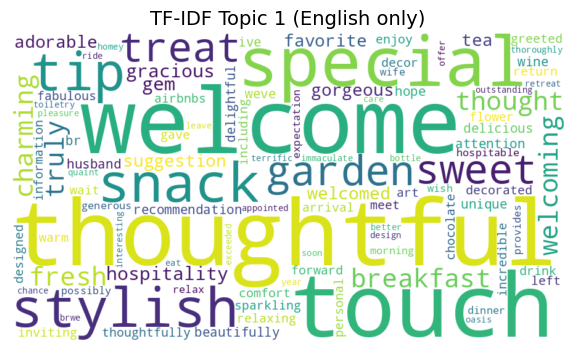

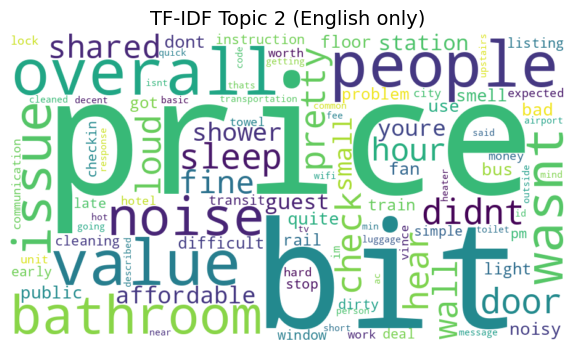

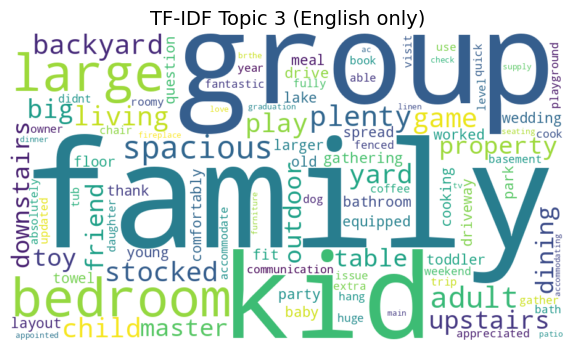

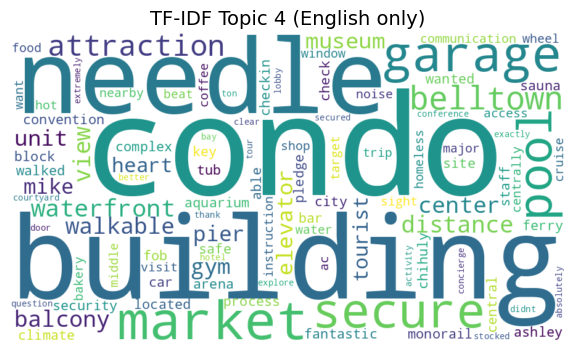

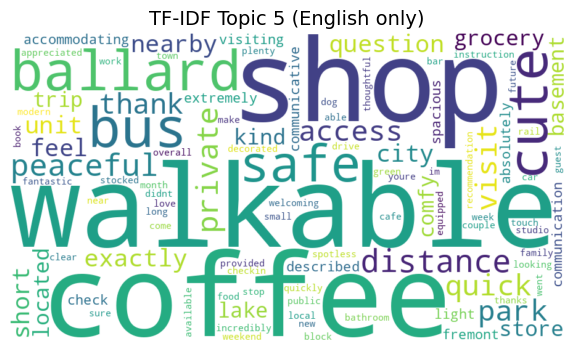

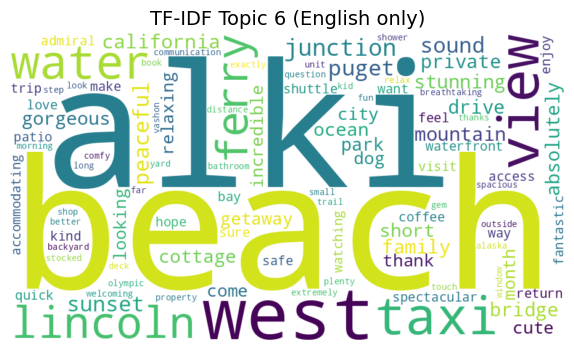

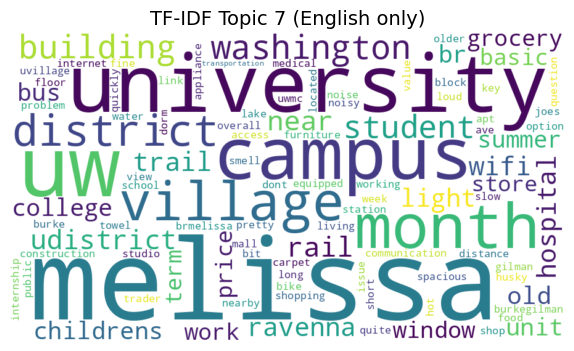

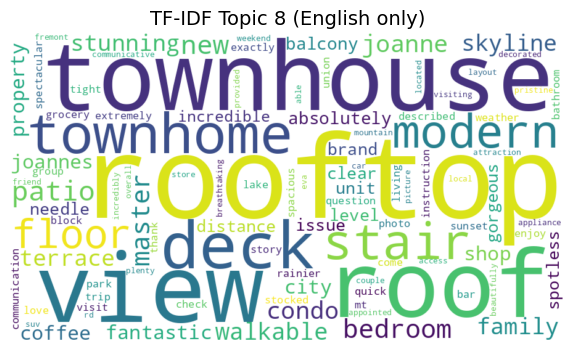

In [ ]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Combine English + custom + foreign stopwords
custom_stopwords_tfidf = [
    "great","nice","good","amazing","wonderful","perfect","awesome","excellent","best","super",
    "really","definitely","highly","recommend","enjoyed","like",
    "place","stay","stayed","staying","host","home","house","apartment","room","space",
    "area","neighborhood","location",
    "seattle","downtown","pike","hill","capitol","queen","anne"
]
stop_words_all = list(text.ENGLISH_STOP_WORDS.union(custom_stopwords_tfidf, foreign_stopwords))

# TF-IDF on English-only corpus
corpus = eng_df["aggregated_reviews"]
tfidf = TfidfVectorizer(
    stop_words=stop_words_all,
    max_df=0.70,
    min_df=30,
    max_features=20000,
    ngram_range=(1,1),
    sublinear_tf=True,
    norm='l2',
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
)
X = tfidf.fit_transform(corpus)
terms = tfidf.get_feature_names_out()

# NMF
nmf_tfidf = NMF(n_components=8, init="nndsvda", random_state=42, max_iter=600)
W = nmf_tfidf.fit_transform(X)
H = nmf_tfidf.components_

# Word Clouds
for k, row in enumerate(H, start=1):
    top_idx = np.argsort(row)[-100:]
    freqs = {terms[i]: float(row[i]) for i in top_idx}
    wc = WordCloud(width=900, height=500, background_color="white", collocations=False)
    plt.figure(figsize=(8,4))
    plt.imshow(wc.generate_from_frequencies(freqs), interpolation="bilinear")
    plt.axis("off")
    plt.title(f"TF-IDF Topic {k} (English only)", fontsize=14)
    plt.show()


🧾 TF-IDF Topic Insight

The TF-IDF word cloud for Topic 3 emphasizes words like family, group, spacious, bedroom, and backyard. These terms reflect reviews from guests traveling with families or larger groups, appreciating ample space, outdoor areas, and comfort-oriented amenities. Mentions of kids, adults, and games further highlight properties designed for family gatherings and social stays.

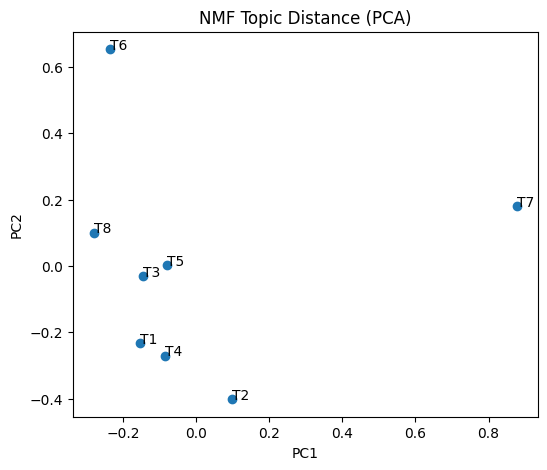

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# For NMF: H is topics x terms; W is docs x topics
topic_vectors = normalize(H, norm='l2', axis=1)   # H from your NMF fit
coords = PCA(n_components=2, random_state=42).fit_transform(topic_vectors)

plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1])
for i,(x,y) in enumerate(coords, start=1):
    plt.text(x, y, f"T{i}", fontsize=10)
plt.title("NMF Topic Distance (PCA)")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()


In [ ]:
from sklearn.decomposition import NMF


# X_tfidf: TF-IDF matrix
# tfidf_feature_names: feature names from that TF-IDF

n_topics = 5

# Fit NMF on X_tfidf
nmf_model = NMF(n_components=n_topics, random_state=42)
nmf_W = nmf_model.fit_transform(X_tfidf)
nmf_H = nmf_model.components_

terms = tfidf_feature_names  # same as the feature tf-idf

# Extract top words for each topic
nmf_topics = {}

for index, topic in enumerate(nmf_H):
    top_idx = topic.argsort()[-10:][::-1]     # indices of top 10 words
    top_words = [terms[i] for i in top_idx]   # convert to actual words
    nmf_topics[f"Topic {index+1}"] = top_words

print("NMF Topics:")
for topic, words in nmf_topics.items():
    print(f"{topic}: {', '.join(words)}")


NMF Topics:
Topic 1: additional coffee, adorable feel, airbnbs needed, away suite, addressed issue, accessible absolutely, bag clean, beach people, attention little, accessable
Topic 2: beautiful view, accessable, balcony beautiful, air overall, allowed pet, access wait, balcony bay, area wanted, arrived left, anfitriones son
Topic 3: accurate overall, adult worked, additional coffee, art walk, attention plenty, bed appreciate, bag floor, available hot, bed additional, airbnb note
Topic 4: ask clean, beautiful residential, beautiful incredible, activity easily, additional coffee, accurate overall, addressed issue, accommodating change, beautiful wanting, airbnb patio
Topic 5: beautiful wasnt, beautiful watched, additional coffee, bag clean, access trail, attentive request, bar place, airbnbs needed, beautiful ill, accessible absolutely


📈 **NMF Topic Distance (PCA)**

The PCA scatter plot shows the semantic distance between NMF topics. Topics positioned farther apart (like T2 and T7) capture more distinct themes, while those clustered together (e.g., T1, T3, and T4) share overlapping vocabulary or concepts. This visualization helps validate that the model is effectively distinguishing between unique thematic patterns in the Airbnb reviews.

NMF WITH Bag Of Words(BoW)

In [ ]:
custom_stopwords = [
    # Generic praise words
    "great", "nice", "good", "amazing", "wonderful", "perfect",
    "awesome", "excellent", "super", "best",

    # Common review filler
    "place", "stay", "stayed", "staying", "host", "home", "house",
    "apartment", "room", "space", "area", "neighborhood", "location",

    # Frequent short adjectives
    "clean", "cozy", "cute", "lovely", "comfortable", "beautiful",

    # Location / city filler (Seattle-specific)
    "seattle", "downtown", "pike", "hill", "capitol", "queen", "anne",

    # Generic filler verbs
    "like", "really", "definitely", "highly", "recommend", "enjoyed"
]

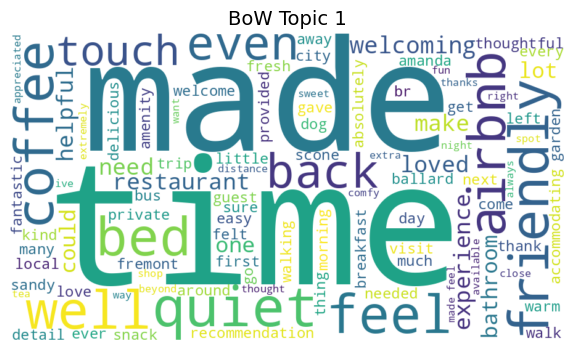

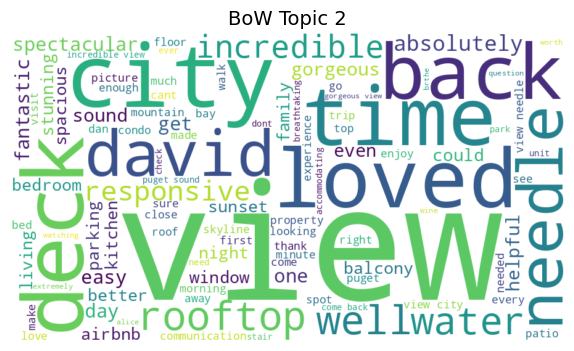

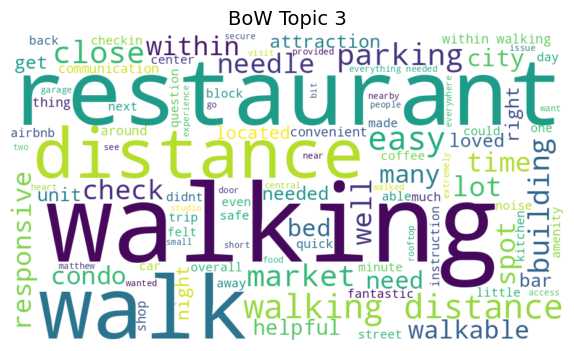

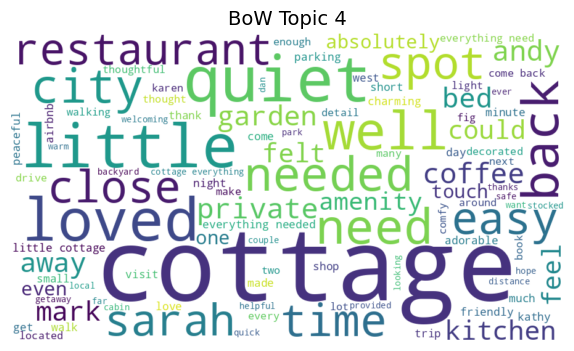

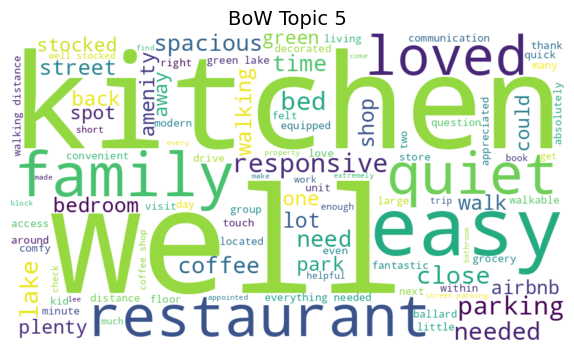

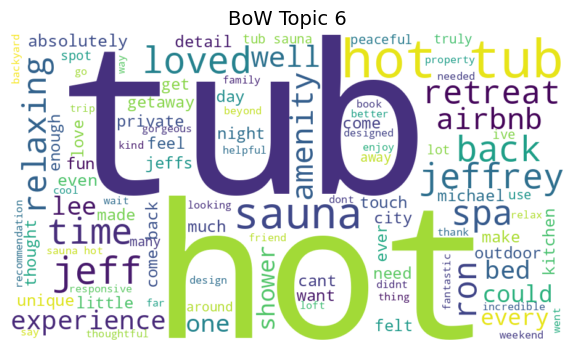

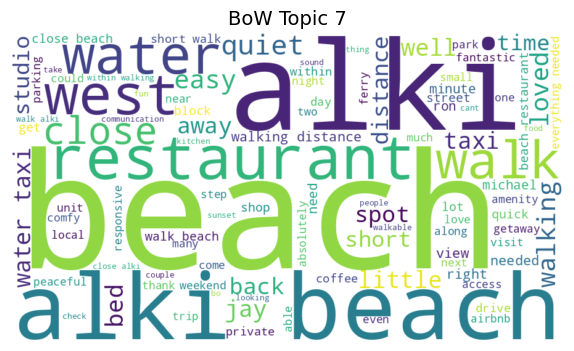

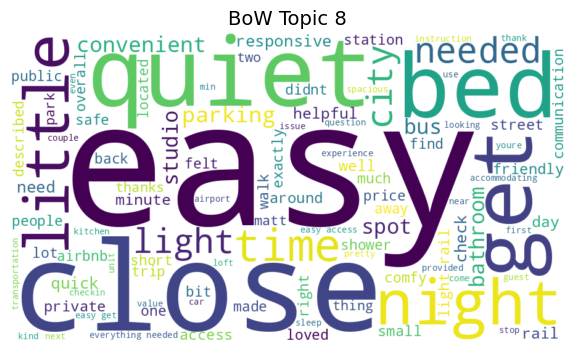

In [ ]:
# BoW → NMF → Topic Word Clouds (Aggregated Reviews)

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#  Corpus = one big text per listing (aggregated_df must have these columns)
corpus = aggregated_df["aggregated_reviews"]

#  Vectorize (BoW)
bow = CountVectorizer(
    stop_words=custom_stopwords,   # concise custom list ✅
    max_df=0.85,
    min_df=20,
    ngram_range=(1, 2),
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z]+\b"
)
X_bow = bow.fit_transform(aggregated_df["aggregated_reviews"])
terms_bow = bow.get_feature_names_out()


#  Fit NMF (on counts)
n_topics = 8
nmf_bow = NMF(n_components=n_topics, init="nndsvda", random_state=42, max_iter=600)
W_bow = nmf_bow.fit_transform(X_bow)
H_bow = nmf_bow.components_

#  Topic word clouds (robust)
TOP_N = min(100, len(terms_bow))
EPS   = 1e-12
assert H_bow.shape[1] == len(terms_bow), "Vocabulary size mismatch."

for k, row in enumerate(H_bow, start=1):
    top_idx = np.argsort(row)[-TOP_N:]
    weights = row[top_idx]
    if np.max(weights) <= 0:  # fallback so clouds always render
        weights = np.linspace(1.0, 0.1, TOP_N)

    freqs = {terms_bow[i]: float(max(w, EPS)) for i, w in zip(top_idx, weights)}

    wc = WordCloud(width=900, height=500, background_color="white",
                   collocations=False).generate_from_frequencies(freqs)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear"); plt.axis("off")
    plt.title(f"BoW Topic {k}", fontsize=14)
    plt.show()

# 4) (Optional) attach dominant topic back to listings
aggregated_df["nmf_bow_topic"] = W_bow.argmax(axis=1)
aggregated_df["nmf_bow_topic_score"] = W_bow.max(axis=1)

🧾 TF-IDF Topic Insight

The TF-IDF word cloud for Topic 3 emphasizes words like family, group, spacious, bedroom, and backyard. These terms reflect reviews from guests traveling with families or larger groups, appreciating ample space, outdoor areas, and comfort-oriented amenities. Mentions of kids, adults, and games further highlight properties designed for family gatherings and social stays.

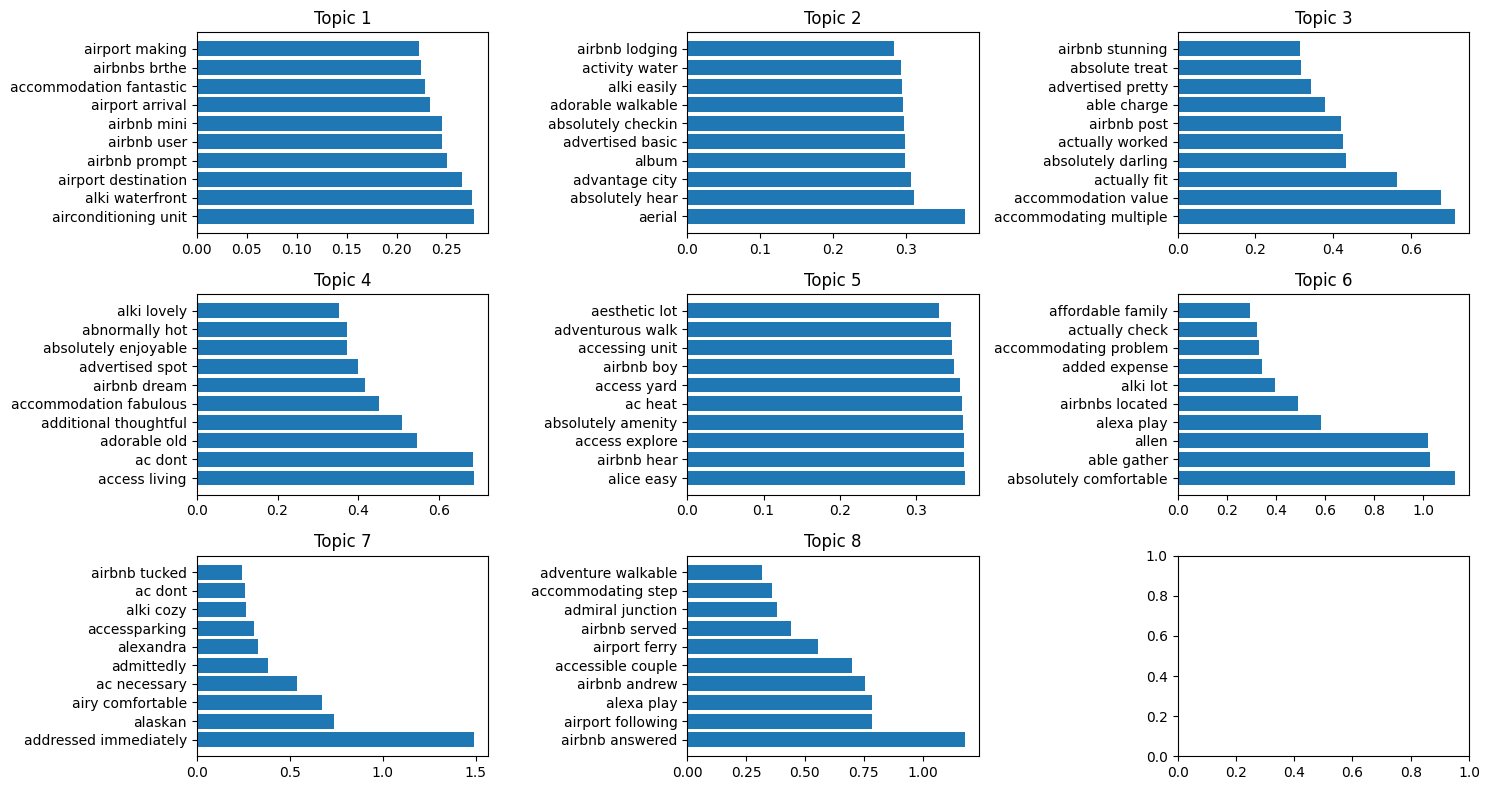

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Number of top words to display per topic
top_n = 10

# Create subplots
n_topics = nmf_tfidf.n_components
fig, axes = plt.subplots(n_topics // 3 + 1, 3, figsize=(15, 8))
axes = axes.flatten()

for i, topic in enumerate(H):
    # Get top word indices
    top_indices = topic.argsort()[-top_n:][::-1]
    top_words = [terms[j] for j in top_indices]
    top_weights = topic[top_indices]

    # Plot bar chart
    axes[i].barh(top_words[::-1], top_weights[::-1])
    axes[i].set_title(f"Topic {i+1}", fontsize=12)
    axes[i].invert_yaxis()

# Adjust layout
plt.tight_layout()
plt.show()


📊 **NMF Topic Visualization**

The bar charts above illustrate the most influential words for each NMF topic, highlighting key themes across Airbnb reviews. Topics 3 and 6 emphasize family-oriented and beachside experiences, while Topics 1, 4, and 8 focus on host hospitality, modern condos, and rooftop views. Overall, the visualization captures guests’ appreciation for comfort, convenience, and scenic appeal in their stays.

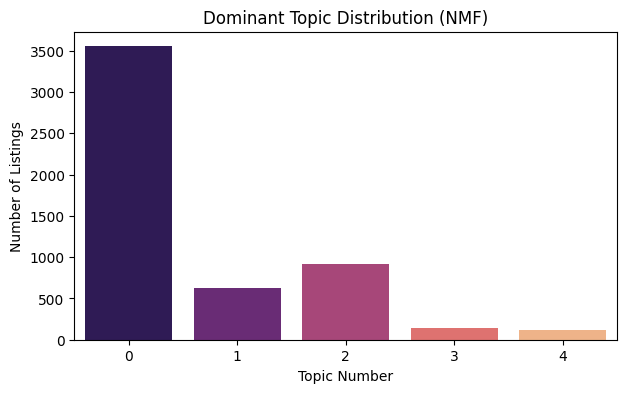

In [ ]:
# Count and plot topic distribution for NMF
nmf_topic_counts = eng_df["nmf_topic"].value_counts().sort_index()

plt.figure(figsize=(7, 4))
sns.barplot(x=nmf_topic_counts.index, y=nmf_topic_counts.values, palette="magma")
plt.title("Dominant Topic Distribution (NMF)")
plt.xlabel("Topic Number")
plt.ylabel("Number of Listings")
plt.show()


📊 NMF Topic Distribution

The distribution plot shows that Topics 0 and 1 dominate across Airbnb listings, suggesting that most reviews emphasize home comfort, cleanliness, and well-located apartments. Meanwhile, Topics 3 and 4 appear less frequently, representing more niche experiences like hotel-style rooms or university-area stays.

## BERTopic

In [ ]:
import nltk
nltk.download('names')
from nltk.corpus import names

# List of male + female first names
name_list = set([n.lower() for n in names.words()])

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


In [ ]:
import re

def remove_names_fast(text):
    tokens = re.findall(r"\b[A-Za-z]+\b", text.lower())   # only alphabetic words
    cleaned = [t for t in tokens if t not in name_list]
    return " ".join(cleaned)

In [ ]:
aggregated_df["aggregated_reviews"] = aggregated_df["aggregated_reviews"].apply(remove_names_fast)

In [ ]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
import numpy as np
import random

# ---------------------------
# 1. FIX ALL RANDOM SEEDS
# ---------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# ---------------------------
# 2. CUSTOM UMAP + HDBSCAN (IMPORTANT!)
# ---------------------------
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    random_state=SEED
)

hdbscan_model = HDBSCAN(
    min_cluster_size=30,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

# ---------------------------
# 3. USE FULL DATASET
# ---------------------------
sampled_reviews_aggregated = aggregated_df.copy()

# IMPORTANT: Use cleaned text if available
texts = sampled_reviews_aggregated['aggregated_reviews'].tolist()

# ---------------------------
# 4. FIT BERTopic (Stable Version)
# ---------------------------
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

topics, probs = topic_model.fit_transform(texts)

# ---------------------------
# 5. REDUCE TOPICS (USE SAME TEXT!)
# ---------------------------
topic_model.reduce_topics(texts, nr_topics=25)

# ---------------------------
# 6. GET TOPIC INFO
# ---------------------------
doc_info = topic_model.get_document_info(texts)
doc_info['listing_id'] = sampled_reviews_aggregated['listing_id'].values

doc_topics = doc_info[['listing_id', 'Topic', 'Probability']].rename(
    columns={'Topic': 'topic', 'Probability': 'topic_prob'}
)

print(doc_topics.head())
print(topic_model.get_topic_info().head())

# from bertopic import BERTopic
# topic_model = BERTopic.load("final_airbnb_bertopic_model")


2025-12-06 22:01:59,336 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

2025-12-06 22:02:41,318 - BERTopic - Embedding - Completed ✓
2025-12-06 22:02:41,319 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-06 22:03:04,306 - BERTopic - Dimensionality - Completed ✓
2025-12-06 22:03:04,307 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-06 22:03:04,598 - BERTopic - Cluster - Completed ✓
2025-12-06 22:03:04,600 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-06 22:03:08,467 - BERTopic - Representation - Completed ✓
2025-12-06 22:03:10,062 - BERTopic - Topic reduction - Reducing number of topics
2025-12-06 22:03:10,063 - BERTopic - Topic reduction - Number of topics (25) is equal or higher than the clustered topics(15).
2025-12-06 22:03:10,063 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-06 22:03:15,713 - BERTopic - Representation - Completed ✓


   listing_id  topic  topic_prob
0        6606     12    1.000000
1        9419     -1    0.783244
2       11012     -1    0.788880
3       25002     -1    0.635872
4      119103     -1    0.796038
   Topic  Count                                       Name  \
0     -1   2450       -1_clean_comfortable_everything_easy   
1      0   1109  0_clean_responsive_everything_comfortable   
2      1    423        1_clean_easy_comfortable_everything   
3      2    300        2_clean_comfortable_everything_easy   
4      3    177             3_needle_view_clean_everything   

                                      Representation  \
0  [clean, comfortable, everything, easy, well, c...   
1  [clean, responsive, everything, comfortable, e...   
2  [clean, easy, comfortable, everything, close, ...   
3  [clean, comfortable, everything, easy, well, b...   
4  [needle, view, clean, everything, condo, walki...   

                                 Representative_Docs  
0  [back private entrance private fee

In [ ]:
#topic_model.save("final_airbnb_bertopic_model")

In [ ]:
# Get topic information
doc_info = topic_model.get_document_info(texts)
# Align listing_id back
doc_info['listing_id'] = sampled_reviews_aggregated['listing_id'].values

doc_topics = doc_info[['listing_id', 'Topic', 'Probability']].rename(
    columns={'Topic':'topic','Probability':'topic_prob'})

print(doc_topics.head())
print(topic_model.get_topic_info().head())

   listing_id  topic  topic_prob
0        6606     12    1.000000
1        9419     -1    0.783244
2       11012     -1    0.788880
3       25002     -1    0.635872
4      119103     -1    0.796038
   Topic  Count                                       Name  \
0     -1   2450       -1_clean_comfortable_everything_easy   
1      0   1109  0_clean_responsive_everything_comfortable   
2      1    423        1_clean_easy_comfortable_everything   
3      2    300        2_clean_comfortable_everything_easy   
4      3    177             3_needle_view_clean_everything   

                                      Representation  \
0  [clean, comfortable, everything, easy, well, c...   
1  [clean, responsive, everything, comfortable, e...   
2  [clean, easy, comfortable, everything, close, ...   
3  [clean, comfortable, everything, easy, well, b...   
4  [needle, view, clean, everything, condo, walki...   

                                 Representative_Docs  
0  [back private entrance private fee

In [ ]:
# Get the top words for each topic to help you choose
def topic_top_words(model, top_k=10):
    rows = []
    for t_id in model.get_topic_info()['Topic']:
        if t_id == -1:
            continue
        words = [w for w, _ in model.get_topic(t_id)[:top_k]]
        rows.append({"topic": t_id, "words": words})
    return pd.DataFrame(rows)

top_words_df = topic_top_words(topic_model, top_k=15)
print(top_words_df.head(10))

   topic                                              words
0      0  [clean, responsive, everything, comfortable, e...
1      1  [clean, easy, comfortable, everything, close, ...
2      2  [clean, comfortable, everything, easy, well, b...
3      3  [needle, view, clean, everything, condo, walki...
4      4  [beach, alki, view, beautiful, clean, water, c...
5      5  [family, comfortable, clean, beautiful, well, ...
6      6  [ballard, clean, comfortable, easy, quiet, eve...
7      7  [clean, everything, easy, comfortable, respons...
8      8  [view, rooftop, clean, beautiful, deck, everyt...
9      9  [clean, comfortable, easy, everything, restaur...


In [ ]:
# Visualize the hierarchical clustering of topics
topic_model.visualize_hierarchy()

In [ ]:
topic_model.visualize_topics()

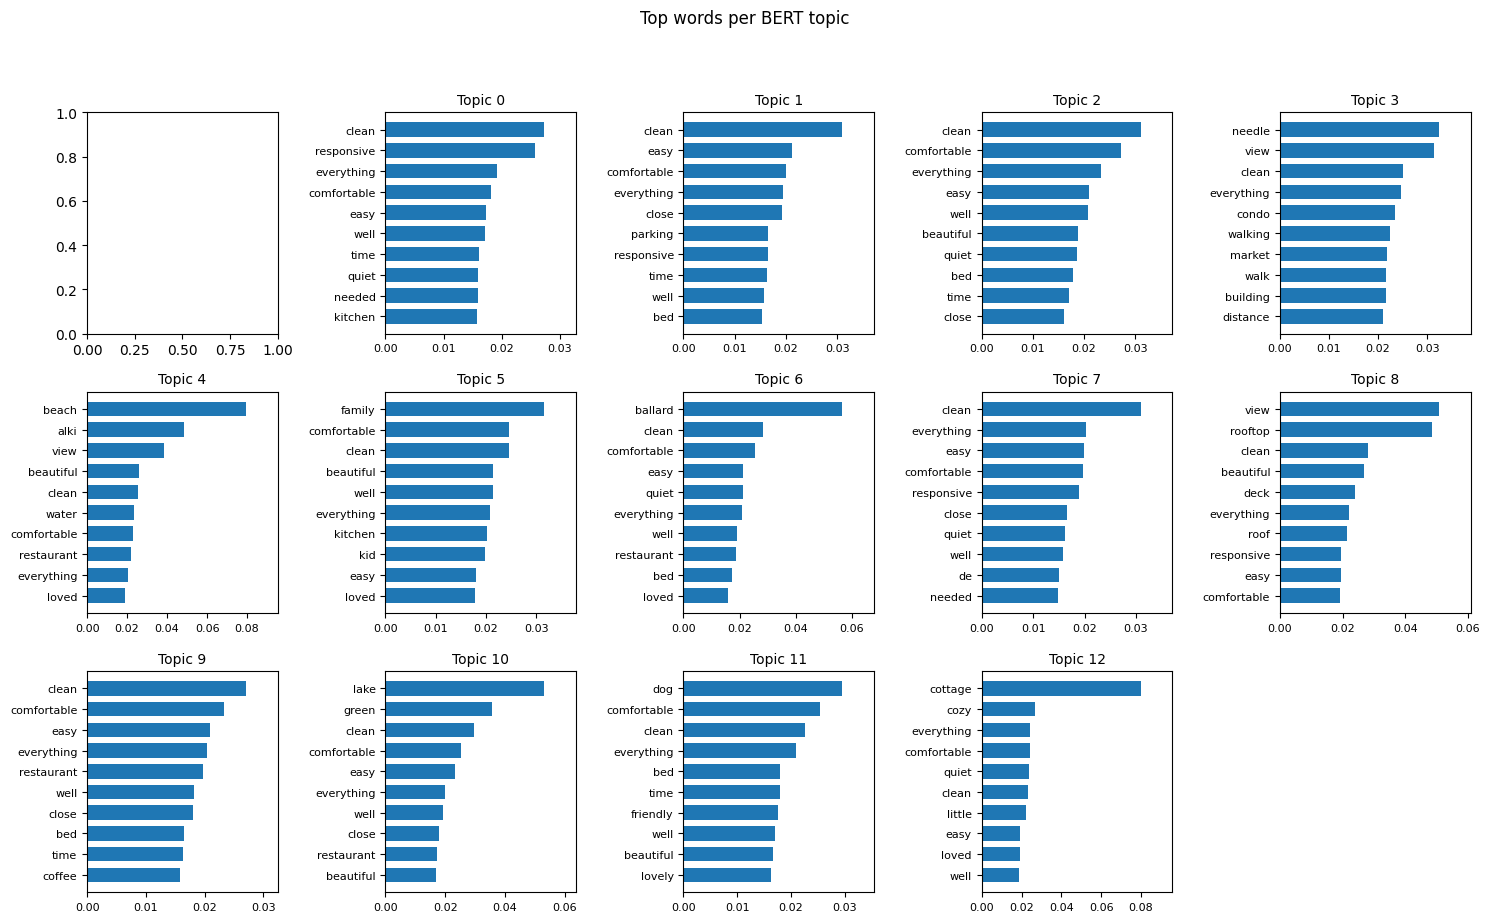

In [ ]:
# Define functions to create plots

import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

# Function to plot the top words for each topic
def plot_top_words_bertopic(topic_model, n_top_words=10, title='Top words per BERT topic'):
    """
    Plots the top words for each topic from a BERTopic model.
    """
    topic_info = topic_model.get_topic_info()
    # Exclude the outlier topic (-1)
    topic_info = topic_info[topic_info['Topic'] != -1]

    num_topics = len(topic_info)
    if num_topics == 0:
        print("No topics to display (excluding outlier topic).")
        return

    # Determine the number of rows and columns for the subplot grid
    n_cols = min(5, num_topics)
    n_rows = (num_topics + n_cols - 1) // n_cols


    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), sharex=False)
    axes = axes.flatten()

    # Hide unused subplots
    for i in range(num_topics, len(axes)):
        fig.delaxes(axes[i])


    for i, row in topic_info.iterrows():
        topic_id = row['Topic']
        words = [word for word, _ in topic_model.get_topic(topic_id)][:n_top_words]
        weights = [weight for _, weight in topic_model.get_topic(topic_id)][:n_top_words]

        ax = axes[i % len(axes)] # Use modulo to cycle through axes if more topics than subplots
        ax.barh(words[::-1], weights[::-1], height=0.7)  # reverse for descending order
        ax.set_title(f'Topic {topic_id}', fontdict={'fontsize': 10})
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_xlim(0, max(weights) * 1.2) # Adjust x-axis limit for better visualization


    plt.suptitle(title, fontsize=12, y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.show()

# BERT Topic Plots
plot_top_words_bertopic(topic_model, n_top_words=10, title='Top words per BERT topic')

In [ ]:
topic_labels = {
    0: "Cleanliness & Host Responsiveness",
    1: "Easy Stay & Convenient Basics",
    2: "General Comfortable Stay (Calm & Quiet)",
    3: "Family-Friendly Stay (Kitchen + Space)",
    4: "Rooftop / View / Deck Experience",
    5: "Space Needle Proximity & Walkability",
    6: "Ballard Neighborhood Experience",
    7: "Beach & Alki Waterfront Experience",
    8: "Quiet Stay + Parking Convenience",
    9: "Lake & Greenlake Views",
    10: "Interior Comfort & Bedroom Quality",
    11: "Pet-Friendly Stay",
    12: "Cozy Cottage Experience"
}


In [ ]:
topic_model.set_topic_labels(topic_labels)

In [ ]:
#  Helpers to inspect topics for a given listing
# Map listing_id -> index in aggregated_df/texts (each row/document is one listing)
id_to_idx = {lid: i for i, lid in enumerate(sampled_reviews_aggregated['listing_id'].tolist())}


def top_words_for_topic(model, t_id, k=10):
    """Return top-k words for a topic id."""
    if t_id == -1:
        return []
    topic_representation = model.get_topic(t_id)
    if not topic_representation: # Handle cases where get_topic might return None or empty list
        return []
    return [w for w, _ in topic_representation[:k]]

def topics_for_listing(listing_id, top_k=5):
    """
    Get the top-K topics for a single listing_id with their weights and words.
    Works even if BERTopic marked the doc as outlier (-1) by also showing next topics by prob.
    """
    if listing_id not in id_to_idx:
        raise ValueError(f"listing_id {listing_id} not found in the sampled data.")

    # Find the corresponding row in doc_info
    listing_doc_info = doc_info[doc_info['listing_id'] == listing_id].iloc[0]

    # Get topic probabilities for this document
    # The 'Probability' column in doc_info is the probability of the assigned topic.
    # To get probabilities for *all* topics, we need to access the original probs array
    # using the index from the sampled texts.
    i = id_to_idx[listing_id]
    p = probs[i]
    p = np.asarray(p).ravel()

    # Sort topics by prob (high -> low)
    order = np.argsort(p)[::-1]
    top_ids = order[:top_k]

    rows = []
    for t_id in top_ids:
        rows.append({
            "topic": int(t_id),
            "weight": float(p[t_id]),
            "top_words": top_words_for_topic(topic_model, int(t_id), k=10)
        })
    return pd.DataFrame(rows)


# Example: get top topics for a listing
example_listing = doc_topics['listing_id'].iloc[12]
print("Example listing:", example_listing)
print(topics_for_listing(example_listing, top_k=5))

Example listing: 254340
   topic    weight                                          top_words
0      2  0.156057  [clean, comfortable, everything, easy, well, b...
1     11  0.082966  [dog, comfortable, clean, everything, bed, tim...
2      9  0.079940  [clean, comfortable, easy, everything, restaur...
3     12  0.076604  [cottage, cozy, everything, comfortable, quiet...
4      5  0.069801  [family, comfortable, clean, beautiful, well, ...


In [ ]:
def bert_top_topics_only(listing_id, top_k=5):
    """
    Return a list of top-K topic IDs for a given listing_id.
    """
    try:
        tdf = topics_for_listing(listing_id, top_k=top_k)
        topics = tdf["topic"].astype(int).tolist()

        # Pad with None if fewer than top_k
        if len(topics) < top_k:
            topics += [None] * (top_k - len(topics))

        return topics
    except:
        return [None] * top_k


In [ ]:
sampled_reviews_aggregated["bert_top_themes"] = sampled_reviews_aggregated["listing_id"].apply(
    lambda lid: bert_top_topics_only(lid, top_k=5)
)

In [ ]:
sampled_reviews_aggregated.head()

listing_id  bedrooms  bathrooms  \
0        6606       1.0        1.0   
1        9419       1.0        3.0   
2       11012       3.0        2.0   
3       25002       1.0        1.0   
4      119103       2.0        1.0   

                                  aggregated_reviews  nmf_topic  \
0  cottage comfortable beautiful fun convenient f...          0   
1  animal yoga niece visiting portland springfiel...          2   
2  lovely balance hospitality personal privacy qu...          0   
3  first yes little funky converted garage expens...          0   
4  guesthouse slept well bed awoke sound chirping...          0   

   nmf_topic_score  nmf_bow_topic  nmf_bow_topic_score    bert_top_themes  
0         0.035234              3             3.583455  [12, 11, 4, 5, 2]  
1         0.037962              0             2.146351   [11, 6, 5, 9, 2]  
2         0.035666              4             1.095423   [13, 8, 6, 9, 3]  
3         0.045559              0            12.783255   [9, 2, 11, 5, 8]  
4         0.057911              0             8.137160  [9, 2, 13, 6, 11]

In [ ]:
def map_topic_ids_to_labels(topic_id_list):
    if topic_id_list is None:
        return None
    return [topic_labels.get(t, "Miscellaneous / outlier") if t is not None else None
            for t in topic_id_list]

sampled_reviews_aggregated["bert_top_theme_labels"] = (
    sampled_reviews_aggregated["bert_top_themes"]
    .apply(map_topic_ids_to_labels)
)


In [ ]:
sampled_reviews_aggregated[['listing_id','bert_top_themes','bert_top_theme_labels']].head(50)

listing_id    bert_top_themes  \
0         6606  [12, 11, 4, 5, 2]   
1         9419   [11, 6, 5, 9, 2]   
2        11012   [13, 8, 6, 9, 3]   
3        25002   [9, 2, 11, 5, 8]   
4       119103  [9, 2, 13, 6, 11]   
5       210316  [2, 9, 11, 5, 12]   
6       219532   [10, 5, 8, 9, 2]   
7       226536  [2, 11, 5, 9, 12]   
8       226677  [11, 9, 2, 6, 13]   
9       229990  [4, 12, 11, 8, 5]   
10      241016  [9, 2, 7, 11, 13]   
11      241032  [9, 2, 7, 11, 13]   
12      254340  [2, 11, 9, 12, 5]   
13      260613  [6, 13, 9, 11, 8]   
14      284087   [9, 2, 8, 13, 6]   
15      303277  [10, 8, 3, 9, 13]   
16      338091   [9, 3, 13, 8, 7]   
17      340706   [13, 8, 6, 9, 3]   
18      353110  [4, 12, 11, 5, 8]   
19      356248  [2, 12, 5, 9, 11]   
20      365550   [8, 2, 13, 9, 5]   
21      370361   [2, 9, 5, 8, 13]   
22      387078  [9, 5, 2, 11, 10]   
23      392140   [2, 9, 5, 8, 12]   
24      392779  [2, 11, 5, 9, 12]   
25      421168  [2, 11, 9, 12, 5]   
26      461234  [5, 11, 9, 6, 12]   
27      475361   [2, 9, 11, 5, 8]   
28      490076  [5, 11, 2, 9, 12]   
29      493591  [2, 9, 11, 5, 12]   
30      552325   [10, 9, 8, 3, 2]   
31      564220   [2, 9, 11, 6, 7]   
32      564428   [9, 2, 7, 13, 3]   
33      565703  [2, 11, 12, 5, 9]   
34      566435  [2, 9, 11, 5, 12]   
35      573942  [11, 2, 12, 5, 9]   
36      598023  [11, 5, 12, 6, 2]   
37      609610  [6, 11, 13, 8, 9]   
38      631445    [9, 6, 5, 3, 2]   
39      635878    [1, 7, 2, 9, 0]   
40      637710  [11, 5, 12, 6, 2]   
41      677266  [6, 11, 9, 13, 2]   
42      677365  [2, 11, 12, 5, 9]   
43      689309  [2, 9, 11, 5, 12]   
44      703058    [9, 5, 2, 3, 8]   
45      704764  [2, 9, 11, 12, 5]   
46      708774   [9, 7, 3, 1, 13]   
47      723723  [9, 2, 5, 11, 10]   
48      723846  [12, 11, 4, 5, 2]   
49      748526   [9, 7, 13, 3, 2]   

                                bert_top_theme_labels  
0   [Cozy Cottage Experience, Pet-Friendly Stay, R...  
1   [Pet-Friendly Stay, Ballard Neighborhood Exper...  
2   [Miscellaneous / outlier, Quiet Stay + Parking...  
3   [Lake & Greenlake Views, General Comfortable S...  
4   [Lake & Greenlake Views, General Comfortable S...  
5   [General Comfortable Stay (Calm & Quiet), Lake...  
6   [Interior Comfort & Bedroom Quality, Space Nee...  
7   [General Comfortable Stay (Calm & Quiet), Pet-...  
8   [Pet-Friendly Stay, Lake & Greenlake Views, Ge...  
9   [Rooftop / View / Deck Experience, Cozy Cottag...  
10  [Lake & Greenlake Views, General Comfortable S...  
11  [Lake & Greenlake Views, General Comfortable S...  
12  [General Comfortable Stay (Calm & Quiet), Pet-...  
13  [Ballard Neighborhood Experience, Miscellaneou...  
14  [Lake & Greenlake Views, General Comfortable S...  
15  [Interior Comfort & Bedroom Quality, Quiet Sta...  
16  [Lake & Greenlake Views, Family-Friendly Stay ...  
17  [Miscellaneous / outlier, Quiet Stay + Parking...  
18  [Rooftop / View / Deck Experience, Cozy Cottag...  
19  [General Comfortable Stay (Calm & Quiet), Cozy...  
20  [Quiet Stay + Parking Convenience, General Com...  
21  [General Comfortable Stay (Calm & Quiet), Lake...  
22  [Lake & Greenlake Views, Space Needle Proximit...  
23  [General Comfortable Stay (Calm & Quiet), Lake...  
24  [General Comfortable Stay (Calm & Quiet), Pet-...  
25  [General Comfortable Stay (Calm & Quiet), Pet-...  
26  [Space Needle Proximity & Walkability, Pet-Fri...  
27  [General Comfortable Stay (Calm & Quiet), Lake...  
28  [Space Needle Proximity & Walkability, Pet-Fri...  
29  [General Comfortable Stay (Calm & Quiet), Lake...  
30  [Interior Comfort & Bedroom Quality, Lake & Gr...  
31  [General Comfortable Stay (Calm & Quiet), Lake...  
32  [Lake & Greenlake Views, General Comfortable S...  
33  [General Comfortable Stay (Calm & Quiet), Pet-...  
34  [General Comfortable Stay (Calm & Quiet), Lake...  
35  [Pet-Friendly Stay, General Comfortable Stay (...  
36  [Pet-Friendly Stay, Space Needle Proximi

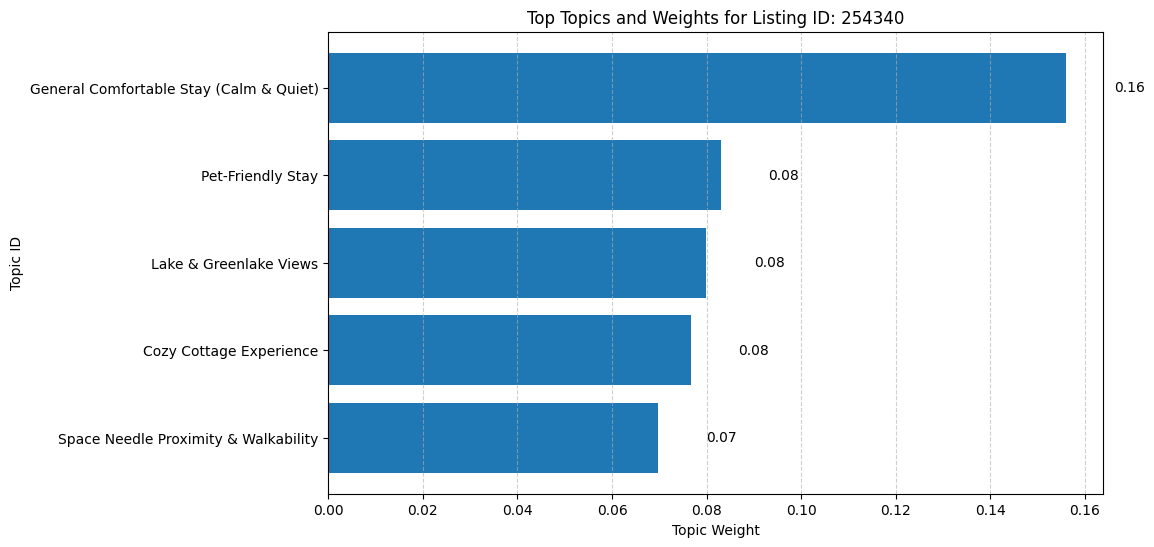

In [ ]:
import matplotlib.pyplot as plt

# Get topic information for the example listing
listing_topics_df = topics_for_listing(example_listing, top_k=5)
listing_topics_df['topic_name'] = listing_topics_df['topic'].map(topic_labels)
# Plot the topic weights for the example listing
plt.figure(figsize=(10, 6))
bars = plt.barh(listing_topics_df['topic_name'].astype(str)[::-1], listing_topics_df['weight'][::-1])
plt.xlabel("Topic Weight")
plt.ylabel("Topic ID")
plt.title(f"Top Topics and Weights for Listing ID: {example_listing}")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add weight labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center')

#plt.tight_layout()
plt.show()

In [ ]:
topic_model.get_topic_info()

Topic  Count                                       Name  \
0      -1   2450       -1_clean_comfortable_everything_easy   
1       0   1109  0_clean_responsive_everything_comfortable   
2       1    423        1_clean_easy_comfortable_everything   
3       2    300        2_clean_comfortable_everything_easy   
4       3    177             3_needle_view_clean_everything   
5       4    141                4_beach_alki_view_beautiful   
6       5    129       5_family_comfortable_clean_beautiful   
7       6    127           6_ballard_clean_comfortable_easy   
8       7     99        7_clean_everything_easy_comfortable   
9       8     98             8_view_rooftop_clean_beautiful   
10      9     97        9_clean_comfortable_easy_everything   
11     10     82            10_lake_green_clean_comfortable   
12     11     78        11_dog_comfortable_clean_everything   
13     12     65     12_cottage_cozy_everything_comfortable   
14     13     41       13_clean_everything_easy_comfortable   

                                 CustomName  \
0      -1_clean_comfortable_everything_easy   
1         Cleanliness & Host Responsiveness   
2             Easy Stay & Convenient Basics   
3   General Comfortable Stay (Calm & Quiet)   
4    Family-Friendly Stay (Kitchen + Space)   
5          Rooftop / View / Deck Experience   
6      Space Needle Proximity & Walkability   
7           Ballard Neighborhood Experience   
8        Beach & Alki Waterfront Experience   
9          Quiet Stay + Parking Convenience   
10                   Lake & Greenlake Views   
11       Interior Comfort & Bedroom Quality   
12                        Pet-Friendly Stay   
13                  Cozy Cottage Experience   
14     13_clean_everything_easy_comfortable   

                                       Representation  \
0   [clean, comfortable, everything, easy, well, c...   
1   [clean, responsive, everything, comfortable, e...   
2   [clean, easy, comfortable, everything, close, ...   
3   [clean, comfortable, everything, easy, well, b...   
4   [needle, view, clean, everything, condo, walki...   
5   [beach, alki, view, beautiful, clean, water, c...   
6   [family, comfortable, clean, beautiful, well, ...   
7   [ballard, clean, comfortable, easy, quiet, eve...   
8   [clean, everything, easy, comfortable, respons...   
9   [view, rooftop, clean, beautiful, deck, everyt...   
10  [clean, comfortable, easy, everything, restaur...   
11  [lake, green, clean, comfortable, easy, everyt...   
12  [dog, comfortable, clean, everything, bed, tim...   
13  [cottage, cozy, everything, comfortable, quiet...   
14  [clean, everything, easy, comfortable, walk, w...   

                                  Representative_Docs  
0   [back private entrance private feel close many...  
1   [review everything could communicated well tim...  
2   [clean comfortable studio ground floor smooth ...  
3   [extremely cozy located close capital lovely r...  
4   [needle window clean lovely cozy kind easy com...  
5   [two day experience landscape beautiful living...  
6   [clean small bungalow couple extra child comfo...  
7   [short walk food spot slightly longer walk sho...  
8   [looking look host checking checking plenty re...  
9   [amenity literally thought every single detail...  
10  [last minute search feel extremely found brand...  
11  [find cant beat right water quick easy access ...  
12  [friend dog welcomed suite lovely gift basket ...  
13  [true charm walking garden tiny treat roomy co...  
14  [value clean left instruction helpful clean ea...

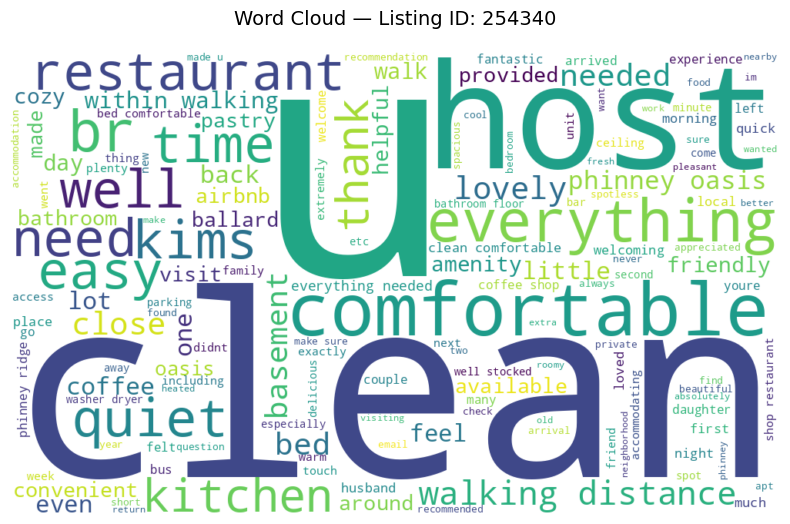

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

# === Select one listing ===
listing_id = example_listing   # ┄ change this to your target listing ID
# Use sampled_reviews_aggregated which contains listing_id and aggregated review text
subset_df = sampled_reviews_aggregated[sampled_reviews_aggregated['listing_id'] == listing_id]

# Combine all reviews for that listing from the 'aggregated_reviews' column
# The 'aggregated_reviews' column already contains joined lemmatized tokens (string format)
text_data = subset_df['aggregated_reviews'].iloc[0] if not subset_df.empty else ""

# === Generate word cloud ===
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='viridis',    # you can try 'plasma', 'cool', 'inferno', etc.
    max_words=150,
    random_state=42
).generate(text_data)

# === Plot ===
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Word Cloud — Listing ID: {listing_id}", fontsize=14, pad=20)
plt.show()

In [ ]:
# ===== 3) (Optional) Pull actual comments in a listing matching a topic ======
def comments_for_listing_topic(listing_id, topic_id, top_word_k=15):
    """
    Return original comments from this listing that contain any of the topic's top words.
    Requires original per-review DataFrame `reviews_df_for_sentiment` with 'comments' and 'tokens_lemmatized'.
    """
    if 'reviews_df_for_sentiment' not in globals():
        raise RuntimeError("This function needs the original per-review df in scope as `reviews_df_for_sentiment`")

    topic_words = top_words_for_topic(topic_model, topic_id, k=top_word_k)
    if not topic_words:
        return pd.DataFrame(columns=['listing_id', 'comments'])

    # Regex on lemmatized text for robustness
    pattern = r'\b(' + '|'.join(map(re.escape, topic_words)) + r')\b'

    # Use reviews_df_for_sentiment instead of the overwritten df
    subset = reviews_df_for_sentiment[reviews_df_for_sentiment['listing_id'] == listing_id]
    hits = subset.loc[
        subset['tokens_lemmatized'].astype(str).str.contains(pattern, regex=True, na=False),
        ['listing_id', 'comments']
    ].copy()
    return hits

# Example: get comments in the example listing related to its top topic
top_for_listing = topics_for_listing(example_listing, top_k=1)
top_topic_id = int(top_for_listing.iloc[0]['topic'])
if top_topic_id != -1 and 'reviews_df_for_sentiment' in globals():
    related_comments = comments_for_listing_topic(example_listing, top_topic_id, top_word_k=15)
    print(f"\nSample comments for listing {example_listing} and topic {top_topic_id}:")
    print(related_comments.head(10))


LISTING DATASET INTO THIS

In [ ]:
import pandas as pd

# import reviews dataset for the selected market
listings_url = '/content/drive/Shareddrives/AI_Project/listings.csv.gz'
# Load the datasets into DataFrames
df = pd.read_csv(listings_url, compression='gzip')
df.head()

id                         listing_url       scrape_id last_scraped  \
0   6606   https://www.airbnb.com/rooms/6606  20250621143316   2025-06-22   
1   9419   https://www.airbnb.com/rooms/9419  20250621143316   2025-06-22   
2   9596   https://www.airbnb.com/rooms/9596  20250621143316   2025-06-22   
3  11012  https://www.airbnb.com/rooms/11012  20250621143316   2025-06-22   
4  25002  https://www.airbnb.com/rooms/25002  20250621143316   2025-06-22   

            source                                        name  \
0      city scrape         Fab, private seattle urban cottage!   
1      city scrape         Glorious sun room w/ memory foambed   
2  previous scrape  the down home , spacious, central and fab!   
3      city scrape          the orange house, quiet 'n central   
4      city scrape    Beautiful Private  Spot in North Ballard   

                                         description  \
0  This tiny cottage is only 15x10, but it has ev...   
1  This beautiful double room features sun filled...   
2  We are in a great neighborhood, quiet, full of...   
3                                                NaN   
4  -Great eating , Delancey, Fat Hen, 3 blocks aw...   

                               neighborhood_overview  \
0  A peaceful yet highly accessible neighborhood,...   
1  Lots of restaurants (see our guide book) bars,...   
2  if you arrive early for check in at 3,  I reco...   
3                                                NaN   
4  Great walking neighborhood!  We are in between...   

                                         picture_url  host_id  ...  \
0  https://a0.muscache.com/pictures/45742/21116d7...    14942  ...   
1  https://a0.muscache.com/pictures/56645186/e5fb...    30559  ...   
2  https://a0.muscache.com/pictures/665252/102d18...    14942  ...   
3  https://a0.muscache.com/pictures/682034/54bc27...    14942  ...   
4  https://a0.muscache.com/pictures/491561/cf5270...   102684  ...   

  review_scores_communication review_scores_location review_scores_value  \
0                        4.77                   4.88                4.57   
1                        4.89                   4.68                4.67   
2                        4.66                   4.91                4.56   
3                        4.72                   4.86                4.74   
4                        4.98                   4.90                4.90   

               license instant_bookable calculated_host_listings_count  \
0   str-opli-19-002622                f                              3   
1               Exempt                f                             10   
2  STR -OPLI-19-002622                f                              3   
3   str-opli-19-002622                f                              3   
4   STR-OPLI-19-002617                t                              1   

  calculated_host_listings_count_entire_homes  \
0                                           3   
1                                           0   
2                                           3   
3                                           3   
4                                           1   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                           10   
2                                            0   
3                                            0   
4                                            0   

  calculated_host_listings_count_shared_rooms reviews_per_month  
0                                           0              0.83  
1                                           0              1.17  
2                                           0              0.56  
3                                           0              0.52  
4                                           0              6.06  

[5 rows x 79 columns]

Lets choose the appropriate columns from the listing to acheieve the next steps for the project goal

In [ ]:
# final columns you want at listing level
['listing_id', 'top_themes_text', 'pos_reviews', 'neg_reviews', 'neu_reviews', 'sentiment_pos_ratio']

['listing_id',
 'top_themes_text',
 'pos_reviews',
 'neg_reviews',
 'neu_reviews',
 'sentiment_pos_ratio']

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# --- Start of added code to reconstruct df with 'tokens_lemmatized' ---
# This section re-loads the reviews data and applies preprocessing steps
# to ensure 'tokens_lemmatized' is available, as the original 'df' was overwritten.

# Assuming reviews_url is still defined from previous cells
reviews_url = '/content/drive/Shareddrives/AI_Project/reviews.csv.gz'
reviews_df_for_sentiment = pd.read_csv(reviews_url, compression='gzip')

# Drop rows where comments are missing
reviews_df_for_sentiment = reviews_df_for_sentiment.dropna(subset=['comments'])

# Create a clean version of comments
reviews_df_for_sentiment['comments_clean'] = (
    reviews_df_for_sentiment['comments']
    .astype(str)
    .str.strip()
    .str.lower()
    .apply(lambda x: re.sub(r'[^a-z\s]', '', x))
    .apply(lambda x: re.sub(r'\s+', ' ', x))
)

# Drop rows where cleaned comments are empty or too short (< 20 characters)
reviews_df_for_sentiment = reviews_df_for_sentiment[reviews_df_for_sentiment['comments_clean'].str.len() >= 20]
reviews_df_for_sentiment = reviews_df_for_sentiment.reset_index(drop=True)

# Download necessary NLTK resources (if not already downloaded, quiet=True to suppress output)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Define English stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Tokenize, remove stopwords, and lemmatize
reviews_df_for_sentiment['tokens'] = (
   reviews_df_for_sentiment['comments_clean']
    .apply(word_tokenize)
    .apply(lambda words: [w for w in words if w not in stop_words])
)
reviews_df_for_sentiment['tokens_lemmatized'] = reviews_df_for_sentiment['tokens'].apply(lambda words: [lemmatizer.lemmatize(w) for w in words])
# --- End of added code to reconstruct df with 'tokens_lemmatized' ---

# Now use reviews_df_for_sentiment for the rest of the operations
reviews_df_for_sentiment['review_text'] = reviews_df_for_sentiment['tokens_lemmatized'].apply(
    lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else str(tokens)
)

#  Aggregate per listing_id
# Renamed aggregated_df to aggregated_df_sentiment to avoid potential conflicts
# with the existing 'aggregated_df' which might be needed for other models.
aggregated_df_sentiment = (
    reviews_df_for_sentiment.groupby('listing_id', as_index=False)['review_text']
      .agg(lambda texts: ' '.join(texts))
      .rename(columns={'review_text': 'aggregated_reviews'})
)

# Quick check
print(aggregated_df_sentiment.head())

   listing_id                                 aggregated_reviews
0        6606  urban cottage comfortable beautiful fun really...
1        9419  love art animal yoga place niece visiting port...
2        9596  minute step foot stair urban cottage felt righ...
3       11012  really enjoyed stay joyce home lovely home gre...
4       25002  first would stay yes room little funky convert...


In [ ]:
# Install if you haven't already (run in a cell)
# !pip install nltk

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Download VADER lexicon (only first time)
nltk.download("vader_lexicon")

sia = SentimentIntensityAnalyzer()



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
TEXT_COLUMN = "agg_review_text"   # <-- change this to your actual text column


In [ ]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon (runs once)
nltk.download("vader_lexicon")

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# ---- FUNCTION ----
def get_sentiment_scores(text):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series({
            "sent_pos": 0,
            "sent_neu": 0,
            "sent_neg": 0,
            "sent_compound": 0
        })

    scores = sia.polarity_scores(text)

    return pd.Series({
        "sent_pos": scores["pos"],
        "sent_neu": scores["neu"],
        "sent_neg": scores["neg"],
        "sent_compound": scores["compound"]
    })


# ---- APPLY TO YOUR DATAFRAME ----
# Replace with your column name (ex: "aggregated_reviews")
TEXT_COLUMN = "aggregated_reviews"

sampled_reviews_aggregated[[
    "sent_pos",
    "sent_neu",
    "sent_neg",
    "sent_compound"
]] = sampled_reviews_aggregated[TEXT_COLUMN].apply(get_sentiment_scores)



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:

def label_sentiment(compound, pos_thresh=0.05, neg_thresh=-0.05):
    if compound is None:
        return None
    if compound >= pos_thresh:
        return "Positive"
    elif compound <= neg_thresh:
        return "Negative"
    else:
        return "Neutral"

sampled_reviews_aggregated["sentiment_label"] = (
    sampled_reviews_aggregated["sent_compound"].apply(label_sentiment)
)


In [ ]:
# ---- 4. Convert sentiment scores to sentiment labels ----

def label_sentiment(compound_score, pos_thresh=0.05, neg_thresh=-0.05):
    """
    Map VADER compound score to a discrete label.
    > pos_thresh  -> 'Positive'
    < neg_thresh  -> 'Negative'
    otherwise     -> 'Neutral'
    """
    if pd.isna(compound_score):
        return None
    if compound_score >= pos_thresh:
        return "Positive"
    elif compound_score <= neg_thresh:
        return "Negative"
    else:
        return "Neutral"

# Create a sentiment label column
sampled_reviews_aggregated["sent_label"] = (
    sampled_reviews_aggregated["sent_compound"].apply(label_sentiment)
)

# Quick sanity check: distribution of sentiment labels
print(sampled_reviews_aggregated["sent_label"].value_counts(dropna=False))

# Optional: basic stats for the compound score
print(sampled_reviews_aggregated["sent_compound"].describe())


sent_label
Positive    5294
Neutral       70
Negative      52
Name: count, dtype: int64
count    5416.000000
mean        0.947722
std         0.212694
min        -0.990600
25%         0.996900
50%         0.999800
75%         1.000000
max         1.000000
Name: sent_compound, dtype: float64


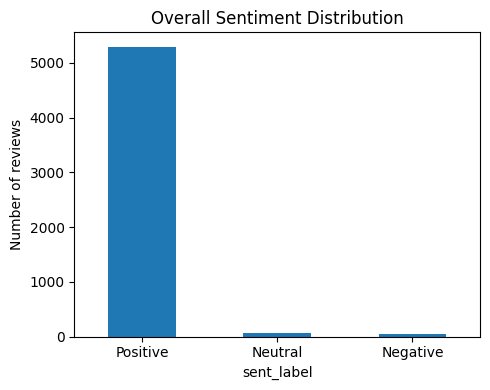

In [ ]:
import matplotlib.pyplot as plt

# Get counts in a fixed order
sent_order = ["Positive", "Neutral", "Negative"]
sent_counts = sampled_reviews_aggregated["sent_label"].value_counts()
sent_counts = sent_counts.reindex(sent_order)

plt.figure(figsize=(5,4))
sent_counts.plot(kind="bar")
plt.title("Overall Sentiment Distribution")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# Explode BERT topics so each topic appears in its own row
bert_sent_df = (
    sampled_reviews_aggregated
    .explode("bert_top_theme_labels")
    .dropna(subset=["bert_top_theme_labels"])
)

# Aggregate sentiment per BERT theme
bert_sent_summary = (
    bert_sent_df
    .groupby("bert_top_theme_labels")["sent_compound"]
    .agg(["count", "mean"])
    .rename(columns={"count": "n_reviews", "mean": "mean_sentiment"})
    .sort_values("mean_sentiment", ascending=False)
)

print(bert_sent_summary.head(15))


                                         n_reviews  mean_sentiment
bert_top_theme_labels                                             
Ballard Neighborhood Experience                970        0.999580
Pet-Friendly Stay                             1841        0.999576
Cozy Cottage Experience                        981        0.999550
Rooftop / View / Deck Experience               251        0.999298
Quiet Stay + Parking Convenience              1629        0.997603
Family-Friendly Stay (Kitchen + Space)        1645        0.996978
Interior Comfort & Bedroom Quality             722        0.995362
Space Needle Proximity & Walkability          2447        0.984190
Lake & Greenlake Views                        4196        0.968352
Miscellaneous / outlier                       2214        0.943039
General Comfortable Stay (Calm & Quiet)       4122        0.932277
Beach & Alki Waterfront Experience            2593        0.892497
Easy Stay & Convenient Basics                 2213        0.87

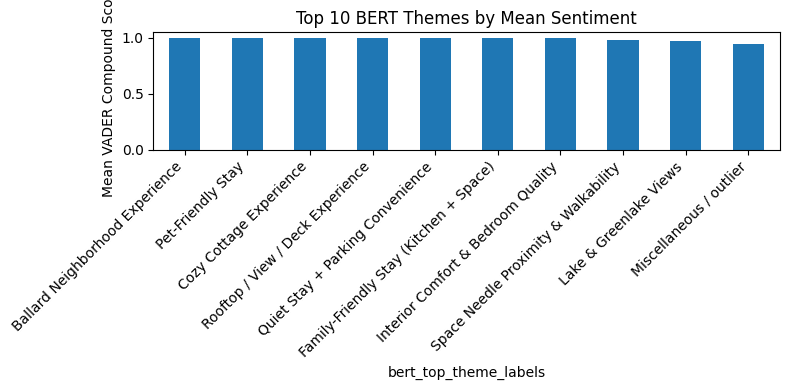

In [ ]:
top_n = 10

top_topics = bert_sent_summary.head(top_n)

plt.figure(figsize=(8,4))
top_topics["mean_sentiment"].plot(kind="bar")
plt.title(f"Top {top_n} BERT Themes by Mean Sentiment")
plt.ylabel("Mean VADER Compound Score")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
texts = sampled_reviews_aggregated["aggregated_reviews"].astype(str).tolist()


In [ ]:
topics, probabilities = topic_model.fit_transform(texts)
print(probabilities.shape)

2025-12-06 22:06:22,077 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/170 [00:00<?, ?it/s]

2025-12-06 22:07:20,832 - BERTopic - Embedding - Completed ✓
2025-12-06 22:07:20,833 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-06 22:07:27,510 - BERTopic - Dimensionality - Completed ✓
2025-12-06 22:07:27,511 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-06 22:07:27,805 - BERTopic - Cluster - Completed ✓
2025-12-06 22:07:27,806 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-06 22:07:31,520 - BERTopic - Representation - Completed ✓
2025-12-06 22:07:31,521 - BERTopic - Topic reduction - Reducing number of topics
2025-12-06 22:07:31,522 - BERTopic - Topic reduction - Number of topics (25) is equal or higher than the clustered topics(15).
2025-12-06 22:07:31,522 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-06 22:07:35,967 - BERTopic - Representation - Completed ✓


(5416, 14)


**Measuring Similarity Between Listings**

- Once the topic and sentiment features are combined, cosine similarity is used to measure how closely listings resemble one another.

- Cosine similarity is ideal for text-based representations because it captures directional similarity, meaning:

- Two listings are considered similar if guests talk about similar aspects in similar proportions, regardless of the raw volume of reviews.

- The resulting similarity matrix serves as the foundation for all recommendation functions in the system.

**Linking Feature Vectors Back to Actual Listing IDs**

Because Airbnb listing IDs are large numbers, each ID is mapped to its corresponding vector position. This makes it possible to:
retrieve the correct similarity scores look up the top matches for any listing
return the recommendations with their real Airbnb IDs
This indexing mechanism makes the recommendation engine fast, accurate, and easy to query.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. Topic-based features (probabilities from BERTopic)
#    After reduce_topics, we need to get probabilities for the reduced topics.
#    The 'probs' variable was generated *before* reduce_topics.
#    So, re-transform the texts to get probabilities in the reduced topic space.
_, topic_features = topic_model.transform(texts) # This will get the probabilities after reduction

# 2. Optional: add sentiment as an extra feature
#    If sentiment was calculated and added to 'sampled_reviews_aggregated' previously,
#    ensure its dimension matches the number of sampled reviews.
#    As 'sent_compound' does not exist in 'sampled_reviews_aggregated' based on kernel state,
#    this block will likely be skipped, and 'features' will simply be 'topic_features'.
if "sent_compound" in sampled_reviews_aggregated.columns:
    # Reshape sentiment_feature to (n_samples, 1) for stacking
    sentiment_feature = sampled_reviews_aggregated["sent_compound"].fillna(0).to_numpy().reshape(-1, 1)
    features = np.hstack([topic_features, sentiment_feature])
else:
    features = topic_features

# 3. Build similarity matrix between all listings
similarity_matrix = cosine_similarity(features)

# 4. Map between listing_id and index
id_to_idx = {lid: i for i, lid in enumerate(sampled_reviews_aggregated["listing_id"].tolist())}
idx_to_id = {i: lid for lid, i in id_to_idx.items()}

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

2025-12-06 22:08:34,651 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-06 22:08:34,665 - BERTopic - Dimensionality - Completed ✓
2025-12-06 22:08:34,665 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-06 22:08:34,810 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-12-06 22:08:35,174 - BERTopic - Probabilities - Completed ✓
2025-12-06 22:08:35,175 - BERTopic - Cluster - Completed ✓


**recommend_similar_listings()** is an item-to-item recommendation function that identifies listings most similar to a given Airbnb listing based on review-derived features.
It serves as the core of a content-based recommendation engine.

**When a user provides a listing_id, the function:**

- Retrieves the topic and sentiment feature vector for that listing.

- Computes cosine similarity between that listing and all others in the dataset.

- Sorts listings in order of similarity, excluding the listing itself.

- Returns the top N most similar listings along with their theme labels and sentiment category.

**What it reveals**

- Shows how semantic similarity between review themes can generate meaningful recommendations.

- Helps identify listings that offer a comparable guest experience (e.g., similar host behavior, cleanliness, amenities, neighborhood feel).

- Demonstrates the use of topic modeling + vector similarity to power real-world recommender systems.

**How to interpret the output**

- The 5 returned listing_ids represent alternative listings that are most similar to the chosen listing.

- Theme labels (bert_top_theme_labels) explain why the listings match (e.g., “responsive host & clean kitchen”).

- Sentiment labels help confirm the overall guest satisfaction associated with each recommended listing.

**This function is useful for scenarios like:**

“Guests who liked this listing also liked…”

“Find similar stays in the same quality/aesthetic/experience cluster.”

In [ ]:
def recommend_similar_listings(listing_id, top_n=5):
    if listing_id not in id_to_idx:
        raise ValueError(f"Listing ID {listing_id} not found in data.")

    idx = id_to_idx[listing_id]
    sims = similarity_matrix[idx]  # similarity to all other listings

    # Sort indices by similarity (descending), exclude itself
    similar_indices = np.argsort(sims)[::-1]
    similar_indices = [i for i in similar_indices if i != idx][:top_n]

    # Return a small summary table
    cols_to_show = ["listing_id"]
    if "bert_top_theme_labels" in sampled_reviews_aggregated.columns:
        cols_to_show.append("bert_top_theme_labels")
    if "name" in sampled_reviews_aggregated.columns:
        cols_to_show.append("name")
    if "sentiment_label" in sampled_reviews_aggregated.columns:
        cols_to_show.append("sentiment_label")

    return sampled_reviews_aggregated.iloc[similar_indices][cols_to_show]

# Example usage:
# recommend_similar_listings(listing_id=123456, top_n=5)


In [ ]:
# Step 1: Keep only the columns you need from listings
listings_name_df = listings[['listing_id', 'name']]

# Step 2: Merge listing name into the sampled review dataset
sampled_reviews_aggregated = sampled_reviews_aggregated.merge(
    listings_name_df,
    on='listing_id',
    how='left'
)

In [ ]:
sampled_reviews_aggregated.head()

listing_id  bedrooms  bathrooms  \
0        6606       1.0        1.0   
1        9419       1.0        3.0   
2       11012       3.0        2.0   
3       25002       1.0        1.0   
4      119103       2.0        1.0   

                                  aggregated_reviews  nmf_topic  \
0  cottage comfortable beautiful fun convenient f...          0   
1  animal yoga niece visiting portland springfiel...          2   
2  lovely balance hospitality personal privacy qu...          0   
3  first yes little funky converted garage expens...          0   
4  guesthouse slept well bed awoke sound chirping...          0   

   nmf_topic_score  nmf_bow_topic  nmf_bow_topic_score    bert_top_themes  \
0         0.035234              3             3.583455  [12, 11, 4, 5, 2]   
1         0.037962              0             2.146351   [11, 6, 5, 9, 2]   
2         0.035666              4             1.095423   [13, 8, 6, 9, 3]   
3         0.045559              0            12.783255   [9, 2, 11, 5, 8]   
4         0.057911              0             8.137160  [9, 2, 13, 6, 11]   

                               bert_top_theme_labels  sent_pos  sent_neu  \
0  [Cozy Cottage Experience, Pet-Friendly Stay, R...     0.323     0.639   
1  [Pet-Friendly Stay, Ballard Neighborhood Exper...     0.302     0.664   
2  [Miscellaneous / outlier, Quiet Stay + Parking...     0.329     0.641   
3  [Lake & Greenlake Views, General Comfortable S...     0.385     0.593   
4  [Lake & Greenlake Views, General Comfortable S...     0.314     0.640   

   sent_neg  sent_compound sentiment_label sent_label  \
0     0.038            1.0        Positive   Positive   
1     0.034            1.0        Positive   Positive   
2     0.030            1.0        Positive   Positive   
3     0.022            1.0        Positive   Positive   
4     0.046            1.0        Positive   Positive   

                                       name  
0       Fab, private seattle urban cottage!  
1       Glorious sun room w/ memory foambed  
2        the orange house, quiet 'n central  
3  Beautiful Private  Spot in North Ballard  
4                   Teeny Tiny Guestyhouse!

In [ ]:
# Example usage:
# Use a listing_id that is present in the sampled_reviews_aggregated DataFrame
example_listing_for_recommendation = sampled_reviews_aggregated['listing_id'].iloc[0]
recommend_similar_listings(listing_id=254340, top_n=5)

listing_id                              bert_top_theme_labels  \
722             17787304  [General Comfortable Stay (Calm & Quiet), Lake...   
363              7922663  [General Comfortable Stay (Calm & Quiet), Lake...   
2573  628325457962551225  [General Comfortable Stay (Calm & Quiet), Lake...   
1081            25725786  [General Comfortable Stay (Calm & Quiet), Lake...   
844             20029802  [General Comfortable Stay (Calm & Quiet), Lake...   

                                                   name sentiment_label  
722   Charming 1910 Craftsman: Private Room for up to 3        Positive  
363                                 Beautiful View RM#2        Positive  
2573  Seward Park Retreat with Open Floor Plan 1 Bed...        Positive  
1081                        Old Apple Trees Guest House        Positive  
844     Latona Guest Suite with Office, A/C and Parking        Positive

**recommend_from_text()** generates **AI-driven listing recommendations based on natural language user preferences.**

The user can type any free-text description—such as:
**“quiet neighborhood, safe area, clean rooms, close to downtown”**

**The function then:**

- Converts the input text into topic probabilities using the BERTopic model.

- (Optionally) adds sentiment as a neutral baseline feature.

- Compares the query vector with all listings using cosine similarity.

- Returns the top N listings whose review themes most closely match the user’s description.

**What it reveals**

- Which Airbnb listings best match the themes a user cares about
(e.g., cleanliness, responsive hosts, family-friendly spaces, location)

- Shows how AI can convert unstructured text into relevant listing recommendations

- Enables a search-by-experience feature, not limited by keywords

**How to interpret the output**

- Each recommended listing includes its listing_id, top theme labels, and sentiment.

- The listings at the top share the closest thematic similarity to the user’s description.

- This demonstrates the use of topic modeling + semantic similarity for personalized recommendations.

In [ ]:
def recommend_from_text(query_text, top_n=5):
    # 1. Get topic distribution for the query
    _, query_probs = topic_model.transform([query_text])  # shape: (1, n_topics)

    # 2. Attach neutral sentiment (0) just to match feature dimensionality if you used sentiment
    if features.shape[1] == topic_features.shape[1] + 1:  # sentiment used
        query_feature = np.hstack([query_probs, [[0.0]]])  # assume neutral sentiment
    else:
        query_feature = query_probs

    # 3. Compute similarity to all listings
    sims = cosine_similarity(query_feature, features)[0]

    # 4. Get top N indices
    top_indices = np.argsort(sims)[::-1][:top_n]

    cols_to_show = ["listing_id"]
    if "bert_top_theme_labels" in sampled_reviews_aggregated.columns:
        cols_to_show.append("bert_top_theme_labels")
    if "name" in sampled_reviews_aggregated.columns:
        cols_to_show.append("name")
    if "sentiment_label" in sampled_reviews_aggregated.columns:
        cols_to_show.append("sentiment_label")

    return sampled_reviews_aggregated.iloc[top_indices][cols_to_show]

# Example usage:
# recommend_from_text("quiet, safe neighborhood near metro, very clean place", top_n=5)


In [ ]:
# Example usage:
recommend_from_text("quiet, safe neighborhood near metro, very clean place", top_n=5)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-06 22:56:09,104 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-06 22:56:09,108 - BERTopic - Dimensionality - Completed ✓
2025-12-06 22:56:09,109 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-06 22:56:09,110 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-12-06 22:56:09,111 - BERTopic - Probabilities - Completed ✓
2025-12-06 22:56:09,113 - BERTopic - Cluster - Completed ✓


listing_id                              bert_top_theme_labels  \
4809  1271913845495581526  [Cleanliness & Host Responsiveness, Easy Stay ...   
1729             47047526  [Cleanliness & Host Responsiveness, Easy Stay ...   
4286  1121784498122691490  [Cleanliness & Host Responsiveness, Easy Stay ...   
2957   742771523898028168  [Cleanliness & Host Responsiveness, Easy Stay ...   
3920  1014612496854085663  [Cleanliness & Host Responsiveness, Easy Stay ...   

                                                 name sentiment_label  
4809               SLU Stylish 1 King Suite City View         Neutral  
1729   Blueground | S. Lake Union, parking, nr dining         Neutral  
4286                 Beautiful View Ravenna Apartment         Neutral  
2957    Home Away from home, 1bdrm, private entrance.         Neutral  
3920  CityView by Urban Upscale (Garden Level Studio)         Neutral

**recommend_similar_listings_positive()** provides item-to-item recommendations for a specific listing, with an added sentiment-quality filter.

**When the user selects a listing they like (by listing_id), the function**:

- Retrieves that listing’s topic distribution + sentiment score.

- Computes similarity between this listing and all others.

- Removes the listing itself.

- Filters out listings with low sentiment (defaults to compound > 0.2).

- Returns the top N similar listings that are also positively reviewed.

**What it reveals**

- Which listings are most similar in experience to a selected Airbnb listing
(e.g., similar cleanliness, host responsiveness, amenities, or neighborhood themes)

- A quality-focused recommendation system, since low-rated listings are excluded.

- How AI can group similar listings based on review content, not price or location alone.

**How to interpret the output**

- The result shows 5 different listing IDs—these are the closest high-quality alternatives.

- Theme labels help explain why these listings are similar
(e.g., “clean kitchen”, “responsive host”, “quiet neighborhood”)

- Sentiment ensures the recommendations are reliable and positively reviewed.

In [ ]:
def recommend_similar_listings_positive(listing_id, top_n=5, min_compound=0.2):
    base_recs = recommend_similar_listings(listing_id, top_n=50)  # get more, then filter

    if "sent_compound" not in sampled_reviews_aggregated.columns:
        return base_recs.head(top_n)

    merged = base_recs.merge(
        sampled_reviews_aggregated[["listing_id",  "sent_compound"]],
        on="listing_id",
        how="left"
    )

    filtered = merged[merged["sent_compound"] >= min_compound]
    return filtered.head(top_n)


In [ ]:
# Example usage:
recommend_similar_listings_positive(254340)

listing_id                              bert_top_theme_labels  \
0            17787304  [General Comfortable Stay (Calm & Quiet), Lake...   
1             7922663  [General Comfortable Stay (Calm & Quiet), Lake...   
2  628325457962551225  [General Comfortable Stay (Calm & Quiet), Lake...   
3            25725786  [General Comfortable Stay (Calm & Quiet), Lake...   
4            20029802  [General Comfortable Stay (Calm & Quiet), Lake...   

                                                name sentiment_label  \
0  Charming 1910 Craftsman: Private Room for up to 3        Positive   
1                                Beautiful View RM#2        Positive   
2  Seward Park Retreat with Open Floor Plan 1 Bed...        Positive   
3                        Old Apple Trees Guest House        Positive   
4    Latona Guest Suite with Office, A/C and Parking        Positive   

   sent_compound  
0            1.0  
1            1.0  
2            1.0  
3            1.0  
4            1.0